In [1]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import date
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn import linear_model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.api import VAR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import ParameterGrid
import numpy as np
import warnings
from sklearn.pipeline import make_pipeline
from sklearn.kernel_ridge import KernelRidge
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_friedman2
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import SGDRegressor
import statsmodels.api as sm
import itertools
import pmdarima as pm
from sklearn.pipeline import make_pipeline
from pmdarima.arima import auto_arima
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from evds import evdsAPI
import pandas as pd
import numpy as np
import requests
import json
from urllib.parse import urlencode
warnings.filterwarnings("ignore")

In [2]:
with open("C:/Users/Bora/Desktop/api.txt") as api:
    key=api.read()



In [3]:
def evds_vericek(series_code,freq):
    params = {
    'series': series_code,
    'startDate': "01-01-2010",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
    }

    url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

    response = requests.get(url=url, headers={'key': key})

    # print(response.request.headers)

    formatted_response = json.loads(response.content)

    seri = formatted_response['items']
    seri = pd.DataFrame(seri)


    seri = seri.drop(columns=['UNIXTIME','Tarih'])
    seri.columns = [f"{series_code}"]
    seri[f"{series_code}"] = pd.to_numeric(seri[f"{series_code}"])

    seri=seri.set_index(pd.date_range(start=params["startDate"],freq="M",periods=len(seri)))

        
    seri=seri.dropna()

    return seri

In [4]:
import yfinance as yf 


In [5]:
params = {
    'series': "TP.DK.USD.S.YTL",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

usd = formatted_response['items']
usd = pd.DataFrame(usd)


usd = usd.drop(columns=['UNIXTIME','Tarih'])
usd.columns = ['USD/TL']
usd['USD/TL'] = pd.to_numeric(usd['USD/TL'])
usd=usd.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(usd)))
usd=usd.dropna()
usd

,USD/TL
2006-01-31,1.334344
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
...,...
2024-05-31,32.247882
2024-06-30,32.521235
2024-07-31,32.894495
2024-08-31,33.621248


In [6]:
params = {
    'series': "TP.FE.OKTG01",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

enf = formatted_response['items']
enf = pd.DataFrame(enf)


enf = enf.drop(columns=['UNIXTIME','Tarih'])
enf.columns = ['TÜFE']
enf['TÜFE'] = pd.to_numeric(enf['TÜFE'])
enf=enf.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(enf)))
enf

,TÜFE
2006-01-31,123.57
2006-02-28,123.84
2006-03-31,124.18
2006-04-30,125.84
2006-05-31,128.20
...,...
2024-04-30,2207.50
2024-05-31,2281.85
2024-06-30,2319.29
2024-07-31,2394.10


In [7]:
params = {
    'series': "TP.PR.ARZ13",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'last',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

money = formatted_response['items']
money = pd.DataFrame(money)


money = money.drop(columns=['UNIXTIME','Tarih'])
money.columns = ['Para Arzi']
money['Para Arzi'] = pd.to_numeric(money['Para Arzi'])
money=money.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(money)))
money=money.pct_change()*100
money=money.dropna()
money

,Para Arzi
2006-02-28,2.121748
2006-03-31,2.927613
2006-04-30,1.084694
2006-05-31,9.121170
2006-06-30,1.433197
...,...
2024-04-30,1.982216
2024-05-31,1.859475
2024-06-30,3.086631
2024-07-31,2.461335


In [8]:
params = {
    'series': "TP.PR.ARZ22",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 1,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

m3 = formatted_response['items']
m3 = pd.DataFrame(m3)


m3 = m3.drop(columns=['UNIXTIME','YEARWEEK'])
m3.columns = ['Tarih','M3']
m3['M3'] = pd.to_numeric(m3['M3'])
m3 = m3.set_index(pd.to_datetime(m3["Tarih"], format="%d-%m-%Y"))
del m3["Tarih"]
m3=m3.pct_change(4)*100
m3=m3.resample('M').last()
m3=m3.dropna()
m3

,M3
Tarih,
2006-02-28,2.204708
2006-03-31,2.711175
2006-04-30,1.323922
2006-05-31,9.308200
2006-06-30,-0.288618
...,...
2024-04-30,2.405048
2024-05-31,3.570039
2024-06-30,3.132936


In [9]:
params = {
    'series': "TP.PR.ARZ01",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 1,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

m1 = formatted_response['items']
m1 = pd.DataFrame(m1)


m1 = m1.drop(columns=['UNIXTIME','YEARWEEK'])
m1.columns = ['Tarih','M1']
m1['M1'] = pd.to_numeric(m1['M1'])
m1 = m1.set_index(pd.to_datetime(m1["Tarih"], format="%d-%m-%Y"))
del m1["Tarih"]
m1=m1.pct_change(4)*100
m1=m1.resample('M').last()
m1=m1.dropna()
m1

,M1
Tarih,
2006-02-28,4.504977
2006-03-31,5.085533
2006-04-30,3.473587
2006-05-31,10.905356
2006-06-30,-0.497357
...,...
2024-04-30,-1.148379
2024-05-31,0.857734
2024-06-30,2.583510


In [10]:
params = {
    'series': "TP.TIG08",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'last',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

issizlik = formatted_response['items']
issizlik = pd.DataFrame(issizlik)


issizlik = issizlik.drop(columns=['UNIXTIME','Tarih'])
issizlik.columns = ['İşsizlik']
issizlik['İşsizlik'] = pd.to_numeric(issizlik['İşsizlik'])
issizlik=issizlik.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(issizlik)))
issizlik=issizlik.dropna()
issizlik

,İşsizlik
2014-01-31,9.2
2014-02-28,9.5
2014-03-31,9.5
2014-04-30,9.7
2014-05-31,9.7
...,...
2024-03-31,8.6
2024-04-30,8.6
2024-05-31,8.5
2024-06-30,9.2


In [11]:
import yfinance as yf
df14=yf.download("BZ=F")["Close"]
df14=pd.DataFrame(df14)
df14.columns=["Brent"]
df14=df14.resample('M').mean()
df14

[*********************100%%**********************]  1 of 1 completed


,Brent
Date,
2007-07-31,76.395000
2007-08-31,71.258696
2007-09-30,77.135263
2007-10-31,82.456957
2007-11-30,92.060953
...,...
2024-05-31,82.991819
2024-06-30,82.889474
2024-07-31,83.717727


In [12]:
params = {
    'series': "TP.KREDI.L001",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 1,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

kredi = formatted_response['items']
kredi = pd.DataFrame(kredi)


kredi = kredi.drop(columns=['UNIXTIME','YEARWEEK'])
kredi.columns = ['Tarih','Kredi']
kredi['Kredi'] = pd.to_numeric(kredi['Kredi'])
kredi = kredi.set_index(pd.to_datetime(kredi["Tarih"], format="%d-%m-%Y"))
del kredi["Tarih"]
kredi=kredi.pct_change(4)*100
kredi=kredi.resample('M').last()
kredi=kredi.dropna()
kredi

,Kredi
Tarih,
2006-02-28,1.559036
2006-03-31,5.768193
2006-04-30,3.124932
2006-05-31,8.993162
2006-06-30,3.965727
...,...
2024-04-30,1.832087
2024-05-31,2.996833
2024-06-30,2.281882


In [13]:
params = {
    'series': "TP.APIFON4",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

pfaiz = formatted_response['items']
pfaiz = pd.DataFrame(pfaiz)


pfaiz = pfaiz.drop(columns=['UNIXTIME','Tarih'])
pfaiz.columns = ['Faiz']
pfaiz['Faiz'] = pd.to_numeric(pfaiz['Faiz'])
pfaiz=pfaiz.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(pfaiz)))
pfaiz=pfaiz.dropna()
pfaiz

,Faiz
2011-01-31,6.438571
2011-02-28,6.250000
2011-03-31,6.250000
2011-04-30,6.267619
2011-05-31,6.250000
...,...
2024-05-31,50.544545
2024-06-30,50.106471
2024-07-31,50.000000
2024-08-31,50.337619


In [14]:
motorin=pd.read_excel("./tuketici fiyat endeksi secilmis maddelere ait ortalama fiyatlar.xls")
motorin=motorin.iloc[-1,:]
motorin=pd.DataFrame(motorin[3:])
motorin=motorin.set_index(pd.date_range(start="2005-01-31",periods=len(motorin),freq="M"))
motorin.columns=["Motorin"]
motorin

,Motorin
2005-01-31,1.75
2005-02-28,1.78
2005-03-31,1.87
2005-04-30,1.94
2005-05-31,1.88
...,...
2024-03-31,42.0568
2024-04-30,42.6763
2024-05-31,41.2854
2024-06-30,41.4054


In [15]:
dogalgaz=pd.read_excel("./tuketici fiyat endeksi secilmis maddelere ait ortalama fiyatlar.xls")
dogalgaz=dogalgaz.iloc[-5,:]
dogalgaz=pd.DataFrame(dogalgaz[3:])
dogalgaz=dogalgaz.set_index(pd.date_range(start="2005-01-31",periods=len(dogalgaz),freq="M"))
dogalgaz.columns=["Doğalgaz"]

In [16]:
elektrik=pd.read_excel("./tuketici fiyat endeksi secilmis maddelere ait ortalama fiyatlar.xls")
elektrik=elektrik.iloc[-6,:]
elektrik=pd.DataFrame(elektrik[3:])
elektrik=elektrik.set_index(pd.date_range(start="2005-01-31",periods=len(elektrik),freq="M"))
elektrik.columns=["Elektrik"]

In [17]:
params = {
    'series': "TP.TRY.MT02",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

mfaiz = formatted_response['items']
mfaiz = pd.DataFrame(mfaiz)


mfaiz = mfaiz.drop(columns=['UNIXTIME','Tarih'])
mfaiz.columns = ['Mevduat Faizi']
mfaiz['Mevduat Faizi'] = pd.to_numeric(mfaiz['Mevduat Faizi'])
mfaiz=mfaiz.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(mfaiz)))
mfaiz=mfaiz.dropna()
mfaiz

,Mevduat Faizi
2006-01-31,15.913333
2006-02-28,15.760000
2006-03-31,15.330000
2006-04-30,15.175000
2006-05-31,14.925000
...,...
2024-04-30,67.567500
2024-05-31,64.538000
2024-06-30,59.695000
2024-07-31,59.382500


In [18]:
params = {
    'series': "TP.BEK.S01.A.S",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

enf_belirsizlik = formatted_response['items']
enf_belirsizlik = pd.DataFrame(enf_belirsizlik)


enf_belirsizlik = enf_belirsizlik.drop(columns=['UNIXTIME','Tarih'])
enf_belirsizlik.columns = ['Enflasyon Belirsizliği']
enf_belirsizlik['Enflasyon Belirsizliği'] = pd.to_numeric(enf_belirsizlik['Enflasyon Belirsizliği'])
enf_belirsizlik=enf_belirsizlik.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(enf_belirsizlik)))
enf_belirsizlik=enf_belirsizlik.dropna()
enf_belirsizlik

,Enflasyon Belirsizliği
2013-01-31,0.32
2013-02-28,0.22
2013-03-31,0.16
2013-04-30,0.26
2013-05-31,0.29
...,...
2024-04-30,0.55
2024-05-31,0.47
2024-06-30,0.48
2024-07-31,0.60


In [19]:
params = {
    'series': "TP.FG.B01.95",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

ito = formatted_response['items']
ito = pd.DataFrame(ito)


ito = ito.drop(columns=['UNIXTIME','Tarih'])
ito.columns = ['İTO']
ito['İTO'] = pd.to_numeric(ito['İTO'])
ito=ito.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(ito)))
ito=ito.pct_change()*100
ito=ito.dropna()
ito

,İTO
2006-02-28,1.005528
2006-03-31,0.137253
2006-04-30,2.088936
2006-05-31,1.595826
2006-06-30,-0.100368
...,...
2024-04-30,4.894259
2024-05-31,3.589407
2024-06-30,3.420697
2024-07-31,4.207686


In [20]:
params = {
    'series': "TP.FE.OKTG04",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

tufec = formatted_response['items']
tufec = pd.DataFrame(tufec)


tufec = tufec.drop(columns=['UNIXTIME','Tarih'])
tufec.columns = ['TÜFE C']
tufec['TÜFE C'] = pd.to_numeric(tufec['TÜFE C'])
tufec=tufec.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(tufec)))
tufec=tufec.pct_change()*100
tufec=tufec.shift(1)
tufec=tufec.dropna()
tufec

,TÜFE C
2006-03-31,-1.101304
2006-04-30,-0.368460
2006-05-31,1.857331
2006-06-30,2.622237
2006-07-31,1.344445
...,...
2024-04-30,3.524351
2024-05-31,3.562117
2024-06-30,3.760332
2024-07-31,1.727271


In [21]:
params = {
    'series': "TP.TUFE1YI.T1",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

üfe = formatted_response['items']
üfe = pd.DataFrame(üfe)


üfe = üfe.drop(columns=['UNIXTIME','Tarih'])
üfe.columns = ['ÜFE']
üfe['ÜFE'] = pd.to_numeric(üfe['ÜFE'])
üfe=üfe.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(üfe)))
üfe=üfe.pct_change()*100
üfe=üfe.dropna()
üfe

,ÜFE
2006-02-28,0.256616
2006-03-31,0.247960
2006-04-30,1.938881
2006-05-31,2.770820
2006-06-30,4.021325
...,...
2024-04-30,3.602753
2024-05-31,1.957875
2024-06-30,1.376326
2024-07-31,1.941578


In [22]:
params = {
    'series': "TP.IHRACATBEC.9999",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

ihracat = formatted_response['items']
ihracat = pd.DataFrame(ihracat)


ihracat = ihracat.drop(columns=['UNIXTIME','Tarih'])
ihracat.columns = ['ÜFE']
ihracat['ÜFE'] = pd.to_numeric(ihracat['ÜFE'])
ihracat=ihracat.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(ihracat)))
ihracat=ihracat.shift(1)
ihracat=ihracat.dropna()
ihracat=ihracat.pct_change()*100
ihracat

,ÜFE
2013-02-28,NaN
2013-03-31,7.272509
2013-04-30,6.926004
2013-05-31,-4.381315
2013-06-30,5.141469
...,...
2024-03-31,5.570999
2024-04-30,7.372996
2024-05-31,-14.751519
2024-06-30,25.347778


In [23]:
params = {
    'series': "TP.ITHALATBEC.9999",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

ithalat = formatted_response['items']
ithalat = pd.DataFrame(ithalat)


ithalat = ithalat.drop(columns=['UNIXTIME','Tarih'])
ithalat.columns = ['ÜFE']
ithalat['ÜFE'] = pd.to_numeric(ithalat['ÜFE'])
ithalat=ithalat.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(ithalat)))
ithalat=ithalat.shift(1)
ithalat=ithalat.dropna()
ithalat=ithalat.pct_change()*100
ithalat

,ÜFE
2013-02-28,NaN
2013-03-31,3.993020
2013-04-30,4.802567
2013-05-31,11.093906
2013-06-30,0.635134
...,...
2024-03-31,6.286018
2024-04-30,7.506729
2024-05-31,-2.524589
2024-06-30,5.057013


In [24]:
params = {
    'series': "TP.PKAUO.S01.A.U",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

anket = formatted_response['items']
anket = pd.DataFrame(anket)


anket = anket.drop(columns=['UNIXTIME','Tarih'])
anket.columns = ['ÜFE']
anket['ÜFE'] = pd.to_numeric(anket['ÜFE'])
anket=anket.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(anket)))
anket=anket.dropna()

anket

,ÜFE
2013-01-31,0.85
2013-02-28,0.53
2013-03-31,0.48
2013-04-30,0.65
2013-05-31,0.46
...,...
2024-04-30,3.25
2024-05-31,3.04
2024-06-30,2.52
2024-07-31,2.77


In [25]:
data=pd.DataFrame()
data["USD/TL"]=usd["USD/TL"].resample('M').mean().rolling(3).mean()
data["Motorin"]=motorin["Motorin"]
data["Motorin1"]=motorin["Motorin"].shift(1)
data["Motorin2"]=motorin["Motorin"]
data["TÜFE"]=enf["TÜFE"]
data["TÜFEt-1"]=data["TÜFE"].shift(1)
data["Doğalgaz"]=dogalgaz["Doğalgaz"]
data["Elektrik"]=elektrik["Elektrik"]
data=data.pct_change()*100
data["M3"]=m3["M3"].rolling(3).mean()
data["ÜFEt1"]=üfe["ÜFE"].shift(1)
data["ÜFEt2"]=üfe["ÜFE"].shift(2)
data["TÜFECt1"]=tufec["TÜFE C"]
data["TÜFECt2"]=tufec["TÜFE C"].shift(1)
data["İTO"]=ito["İTO"]
data["İhracat"]=ihracat["ÜFE"]
data["İthalat"]=ithalat["ÜFE"]
data["Anket"]=anket["ÜFE"]
data

,USD/TL,Motorin,Motorin1,Motorin2,TÜFE,TÜFEt-1,Doğalgaz,Elektrik,M3,ÜFEt1,ÜFEt2,TÜFECt1,TÜFECt2,İTO,İhracat,İthalat,Anket
2006-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-02-28,NaN,0.000000,1.485149,0.000000,0.218500,NaN,-2.040816,0.000000,NaN,NaN,NaN,NaN,NaN,1.005528,NaN,NaN,NaN
2006-03-31,NaN,0.975610,0.000000,0.975610,0.274548,0.218500,6.250000,0.000000,NaN,0.256616,NaN,-1.101304,NaN,0.137253,NaN,NaN,NaN
2006-04-30,0.075089,2.898551,0.975610,2.898551,1.336769,0.274548,0.000000,0.000000,2.079935,0.247960,0.256616,-0.368460,-1.101304,2.088936,NaN,NaN,NaN
2006-05-31,2.353679,4.694836,2.898551,4.694836,1.875397,1.336769,1.960784,0.000000,4.447765,1.938881,0.247960,1.857331,-0.368460,1.595826,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31,1.565526,-3.259186,1.473008,-3.259186,3.368063,3.179759,28.892737,0.000000,2.887641,3.602753,3.294983,3.562117,3.524351,3.589407,-14.751519,-2.524589,3.04
2024-06-30,0.553511,0.290660,-3.259186,0.290660,1.640774,3.368063,1.154163,0.000000,3.036008,1.957875,3.602753,3.760332,3.562117,3.420697,25.347778,5.057013,2.52
2024-07-31,0.581912,9.118859,0.290660,9.118859,3.225556,1.640774,2.601950,37.997137,3.247856,1.376326,1.957875,1.727271,3.760332,4.207686,-21.356708,-18.787382,2.77
2024-08-31,1.406221,0.000000,0.000000,0.000000,2.474416,3.225556,0.000000,0.000000,3.381660,1.941578,1.376326,2.453794,1.727271,1.727957,NaN,NaN,2.55


In [26]:
data["Kredi"]=kredi["Kredi"].rolling(3).mean()
data["ParaArzi"]=money["Para Arzi"].rolling(3).mean()
data["İşsizlik"]=issizlik["İşsizlik"]
data["Enflasyon Belirsizliği"]=enf_belirsizlik
data["Mevduat Faizi"]=mfaiz["Mevduat Faizi"]
data["Politika Faizi"]=pfaiz["Faiz"]
data["Zam"]=0
data=data[['USD/TL', 'Motorin','M3', 'Enflasyon Belirsizliği','Zam',"Doğalgaz","Elektrik",'Motorin1','Motorin2','TÜFEt-1','ParaArzi','Kredi','İhracat','İthalat','Mevduat Faizi','Anket','İşsizlik','Politika Faizi','ÜFEt2','TÜFECt2','ÜFEt1','TÜFECt1','İTO','TÜFE']]
data.iloc[:12,4]=380.46
data.iloc[12:18,4]=403.03
data.iloc[18:24,4]=419.15
data.iloc[24:30,4]=481.55
data.iloc[30:36,4]=503.26
data.iloc[36:42,4]=527.13
data.iloc[42:48,4]=546.48
data.iloc[48:54,4]=576.57
data.iloc[54:60,4]=599.12
data.iloc[60:66,4]=629.96
data.iloc[66:72,4]=658.95
data.iloc[72:78,4]=701.13
data.iloc[78:84,4]=739.79
data.iloc[84:90,4]=773.01
data.iloc[90:96,4]=803.68
data.iloc[96:102,4]=846.00
data.iloc[102:108,4]=891.03
data.iloc[108:114,4]=949.07
data.iloc[114:120,4]=1000.54
data.iloc[120:132,4]=1300.99
data.iloc[132:144,4]=1404.06
data.iloc[144:156,4]=1603.12
data.iloc[156:168,4]=2020.9
data.iloc[168:180,4]=2324.71
data.iloc[180:192,4]=2825.90
data.iloc[192:198,4]=4253.4
data.iloc[198:204,4]=5500.35
data.iloc[204:210,4]=8506.8
data.iloc[210:216,4]=11402.33
data.iloc[216:,4]=17002
data["Zam"]=data["Zam"].pct_change()*100
data=data.fillna(0)
data["İşsizlik"].iloc[-2:]=8.4


data=data.loc["2014-01-31":]
data["TÜFE"].loc["2023-05-31"]+=2.88
data["ÜFEt1"].iloc[-1]=1.68
data["ÜFEt2"].iloc[-2:]=[1.94,1.68]
data["TÜFECt1"].iloc[-1]=2.99
data["TÜFECt2"].iloc[-1]=2.45
data["İhracat"].iloc[-2:]=[21.23,-1.99]
data["İthalat"].iloc[-2:]=[18.96,-9.26]
data

,USD/TL,Motorin,M3,Enflasyon Belirsizliği,Zam,Doğalgaz,Elektrik,Motorin1,Motorin2,TÜFEt-1,...,Mevduat Faizi,Anket,İşsizlik,Politika Faizi,ÜFEt2,TÜFECt2,ÜFEt1,TÜFECt1,İTO,TÜFE
2014-01-31,3.732429,2.881984,2.086700,0.37,5.265777,0.065445,-0.223152,1.603103,2.881984,0.460607,...,9.0220,1.06,9.2,7.503636,0.618013,0.625859,1.106494,-0.111246,0.333618,1.978080
2014-02-28,3.033477,1.685899,1.867150,0.31,0.000000,0.280295,0.000000,2.881984,1.685899,1.978080,...,10.6275,0.69,9.5,10.070500,1.106494,-0.111246,3.319203,0.308798,1.009554,0.428192
2014-03-31,2.465778,-2.278097,0.972739,0.16,0.000000,0.428585,0.000000,1.685899,-2.278097,0.428192,...,11.3125,0.65,9.5,10.200952,3.319203,0.308798,1.383675,0.701489,0.989257,1.125608
2014-04-30,-1.344724,-6.214384,0.288775,0.23,0.000000,0.055664,0.307520,-2.278097,-6.214384,1.125608,...,11.0200,0.76,9.7,10.046190,1.383675,0.701489,0.736212,1.197755,2.649799,1.344970
2014-05-31,-1.859714,-0.561578,0.043893,0.26,0.000000,-0.009272,0.000000,-6.214384,-0.561578,1.344970,...,10.4940,0.63,9.7,9.891000,0.736212,1.197755,0.085477,2.119546,0.211698,0.395224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31,1.565526,-3.259186,2.887641,0.47,0.000000,28.892737,0.000000,1.473008,-3.259186,3.179759,...,64.5380,3.04,8.5,50.544545,3.294983,3.524351,3.602753,3.562117,3.589407,3.368063
2024-06-30,0.553511,0.290660,3.036008,0.48,0.000000,1.154163,0.000000,-3.259186,0.290660,3.368063,...,59.6950,2.52,9.2,50.106471,3.602753,3.562117,1.957875,3.760332,3.420697,1.640774
2024-07-31,0.581912,9.118859,3.247856,0.60,0.000000,2.601950,37.997137,0.290660,9.118859,1.640774,...,59.3825,2.77,8.8,50.000000,1.957875,3.760332,1.376326,1.727271,4.207686,3.225556
2024-08-31,1.406221,0.000000,3.381660,0.49,0.000000,0.000000,0.000000,0.000000,0.000000,3.225556,...,59.0240,2.55,8.4,50.337619,1.940000,1.727271,1.941578,2.453794,1.727957,2.474416


In [27]:
data["Motorin"].iloc[-2]=-1.69
data["Motorin2"].iloc[-2]=-1.69
data["Motorin"].iloc[-1]=-3.05
data["Motorin2"].iloc[-1]=-3.05

In [28]:
data["Motorin"]=data["Motorin"].rolling(2).mean()
data["Kredi"]=kredi["Kredi"].shift(1).rolling(2).mean()
data["Kredi2"]=kredi["Kredi"].rolling(3).mean()

In [31]:
data["ParaArzi"].iloc[-1]=1.8066

In [34]:
data["M3"].iloc[-1]=2.07
data["Kredi"].iloc[-1]=2.3320
data["Kredi2"].iloc[-1]=1.6347
data["Anket"].iloc[-1]=2.22
data["Enflasyon Belirsizliği"].iloc[-1]=0.49

## Cari Ay Enflasyon Tahmini

In [35]:
data=data.dropna()

In [36]:
from sklearn.model_selection import train_test_split
features=['USD/TL', 'Motorin','Motorin1','Motorin2', 'M3', 'Enflasyon Belirsizliği', 'Zam','Elektrik', 'TÜFEt-1',
       'ParaArzi', 'Kredi', 'İhracat', 'İthalat', 'Mevduat Faizi', 'Anket',
       'İşsizlik', 'Politika Faizi', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1', 'TÜFECt1', 'TÜFE']
data1=data[features]
from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
X=scaled_data
X=X.iloc[:,:-1]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=scaled_data.columns[:-1])
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-8,:],X.iloc[-8:,:]
y_train,y_test=y[:-8],y[-8:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)

In [37]:
features=['USD/TL', 'Motorin','Motorin1','Motorin2', 'M3', 'Enflasyon Belirsizliği', 'Zam','Elektrik', 'TÜFEt-1',
       'ParaArzi', 'Kredi', 'İhracat', 'İthalat', 'Mevduat Faizi', 'Anket',
       'İşsizlik', 'Politika Faizi', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1', 'TÜFECt1', 'TÜFE']

data1=data[features]
from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
scaled_data

,USD/TL,Motorin,Motorin1,Motorin2,M3,Enflasyon Belirsizliği,Zam,Elektrik,TÜFEt-1,ParaArzi,...,İthalat,Mevduat Faizi,Anket,İşsizlik,Politika Faizi,ÜFEt2,TÜFECt2,ÜFEt1,TÜFECt1,TÜFE
0,0.239862,0.042052,0.122407,-0.041958,-0.268959,-0.553349,-0.286359,-0.210711,0.037740,-0.230828,...,-1.368187,-0.639344,-0.653956,-0.987149,-0.552661,-0.385268,-0.898194,0.364605,-0.713312,-0.657717
1,0.068549,-0.367038,-0.040610,-0.579071,-0.795998,-0.938986,-0.286359,-0.210711,-0.655187,-0.693304,...,-0.645125,-0.586740,-0.683832,-0.987149,-0.540605,0.365235,-0.700480,-0.292044,-0.528106,-0.346209
2,-1.081334,-0.993370,-0.580873,-1.112431,-1.199030,-0.759022,-0.286359,-0.172265,-0.343385,-1.082052,...,1.092309,-0.609202,-0.601672,-0.856752,-0.554908,-0.291254,-0.515641,-0.511703,-0.294051,-0.248228
3,-1.236741,-0.857285,-1.117360,-0.346487,-1.343329,-0.681894,-0.286359,-0.210711,-0.245312,-1.299530,...,-0.008061,-0.649596,-0.698771,-0.856752,-0.569250,-0.510859,-0.282049,-0.732472,0.140697,-0.672443
4,-1.154087,-0.146616,-0.346925,0.102182,-0.952997,-0.527640,-0.286359,-0.210711,-0.669926,-0.949565,...,-0.044329,-0.681580,-1.005004,-0.856752,-0.611987,-0.731575,0.151836,-0.938215,-0.149935,-0.710156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,-0.203117,-0.461696,-0.069626,-0.712007,0.332374,-0.142003,-0.286359,-0.210711,0.574990,-0.121979,...,-0.291290,3.500643,1.101286,-1.639136,3.187895,0.357021,0.813075,0.460803,0.821061,0.655410
124,-0.508510,-0.555433,-0.714588,-0.231010,0.419801,-0.116294,-0.286359,-0.210711,0.659178,0.001776,...,0.382526,3.128732,0.712892,-1.182745,3.147409,0.461410,0.830852,-0.097241,0.914546,-0.116104
125,-0.499939,0.425895,-0.230771,0.965193,0.544634,0.192216,-0.286359,4.539769,-0.113063,0.087714,...,-1.736647,3.104733,0.899620,-1.443540,3.137569,-0.096498,0.924151,-0.294538,-0.044313,0.591757
126,-0.251190,0.268869,-0.270386,-0.499386,0.623479,-0.090585,-0.286359,-0.210711,0.595465,0.436287,...,1.618155,3.077203,0.735299,-1.704335,3.168771,-0.102561,-0.032807,-0.102770,0.298339,0.256252


In [38]:
features=['USD/TL', 'Motorin','Motorin1','Motorin2', 'M3', 'Enflasyon Belirsizliği', 'Zam','Elektrik', 'TÜFEt-1',
       'ParaArzi', 'Kredi','Kredi2', 'İhracat', 'İthalat', 'Mevduat Faizi', 'Anket',
       'İşsizlik', 'Politika Faizi', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1', 'TÜFECt1', 'TÜFE']

data1=data[features]
from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
scaled_data

,USD/TL,Motorin,Motorin1,Motorin2,M3,Enflasyon Belirsizliği,Zam,Elektrik,TÜFEt-1,ParaArzi,...,İthalat,Mevduat Faizi,Anket,İşsizlik,Politika Faizi,ÜFEt2,TÜFECt2,ÜFEt1,TÜFECt1,TÜFE
0,0.239862,0.042052,0.122407,-0.041958,-0.268959,-0.553349,-0.286359,-0.210711,0.037740,-0.230828,...,-1.368187,-0.639344,-0.653956,-0.987149,-0.552661,-0.385268,-0.898194,0.364605,-0.713312,-0.657717
1,0.068549,-0.367038,-0.040610,-0.579071,-0.795998,-0.938986,-0.286359,-0.210711,-0.655187,-0.693304,...,-0.645125,-0.586740,-0.683832,-0.987149,-0.540605,0.365235,-0.700480,-0.292044,-0.528106,-0.346209
2,-1.081334,-0.993370,-0.580873,-1.112431,-1.199030,-0.759022,-0.286359,-0.172265,-0.343385,-1.082052,...,1.092309,-0.609202,-0.601672,-0.856752,-0.554908,-0.291254,-0.515641,-0.511703,-0.294051,-0.248228
3,-1.236741,-0.857285,-1.117360,-0.346487,-1.343329,-0.681894,-0.286359,-0.210711,-0.245312,-1.299530,...,-0.008061,-0.649596,-0.698771,-0.856752,-0.569250,-0.510859,-0.282049,-0.732472,0.140697,-0.672443
4,-1.154087,-0.146616,-0.346925,0.102182,-0.952997,-0.527640,-0.286359,-0.210711,-0.669926,-0.949565,...,-0.044329,-0.681580,-1.005004,-0.856752,-0.611987,-0.731575,0.151836,-0.938215,-0.149935,-0.710156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,-0.203117,-0.461696,-0.069626,-0.712007,0.332374,-0.142003,-0.286359,-0.210711,0.574990,-0.121979,...,-0.291290,3.500643,1.101286,-1.639136,3.187895,0.357021,0.813075,0.460803,0.821061,0.655410
124,-0.508510,-0.555433,-0.714588,-0.231010,0.419801,-0.116294,-0.286359,-0.210711,0.659178,0.001776,...,0.382526,3.128732,0.712892,-1.182745,3.147409,0.461410,0.830852,-0.097241,0.914546,-0.116104
125,-0.499939,0.425895,-0.230771,0.965193,0.544634,0.192216,-0.286359,4.539769,-0.113063,0.087714,...,-1.736647,3.104733,0.899620,-1.443540,3.137569,-0.096498,0.924151,-0.294538,-0.044313,0.591757
126,-0.251190,0.268869,-0.270386,-0.499386,0.623479,-0.090585,-0.286359,-0.210711,0.595465,0.436287,...,1.618155,3.077203,0.735299,-1.704335,3.168771,-0.102561,-0.032807,-0.102770,0.298339,0.256252


In [39]:
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,GRU,SimpleRNN
import keras
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import l2,l1
from sklearn.model_selection import TimeSeriesSplit

def objective(trial):
 
    selected_features=['Kredi2', 'USD/TL', 'Motorin2', 'Zam','ParaArzi','Enflasyon Belirsizliği','İşsizlik']







    X=scaled_data[selected_features]
    y=scaled_data["TÜFE"]
    X=np.array(X)
    y=np.array(y).reshape(-1,1)
    X=pd.DataFrame(X,columns=selected_features)
    y=pd.DataFrame(y,columns=["TÜFE"])
    X_train,X_test=X.iloc[:-7,:],X.iloc[-7:,:]
    y_train,y_test=y[:-7],y[-7:]
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)


    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1)
    units1 = trial.suggest_int('units1', 1, 512)
    batch_size = trial.suggest_int('batch_size', 2, 64)
    activation1 = trial.suggest_categorical('activation1', ['tanh','selu','relu','linear','sigmoid'])
    optimizer = trial.suggest_categorical('optimizer', ['adam'])
    rlrate=trial.suggest_float('rlrate',0.001,0.999)
    keras.utils.set_random_seed(42)
    early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
    model = Sequential()   
    model.add(Dense(units=units1,activation=activation1,input_dim=(X_train.shape[1])))
    model.add(Dropout(rlrate))
    model.add(Dense(units=1))

    if optimizer == 'adam':
       optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
       optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == 'SGD':
       optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate) 

    

    

    

    model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])

    # Train model
    model.fit(X_train, y_train, epochs=1000, batch_size=batch_size,callbacks=[early_stopping],verbose=0,validation_data=(X_val,y_val))

    # Evaluate model
    y_pred = model.predict(X_test)
    tahminler=pd.DataFrame(scaler2.inverse_transform(y_test))
    tahminler.columns=["TÜFE"]
    tahminler["Tahmin"]=scaler2.inverse_transform(y_pred)
    tahminler=tahminler.set_index(data.index[-7:])
    tahminler["Tahmin"].loc["2024-05-31"]+=0.66
    mse=mean_squared_error(tahminler["TÜFE"].iloc[:-1],tahminler["Tahmin"].iloc[:-1])
    print(tahminler["Tahmin"].iloc[-1])


    return mse # Return validation accuracy as the objective

"""study = optuna.create_study(direction='minimize')  # or 'minimize' depending on your objective
study.optimize(objective, n_trials=400)  # You can adjust the number of trials

# Print the best hyperparameters
print('Best hyperparameters:', study.best_params)"""

"study = optuna.create_study(direction='minimize')  # or 'minimize' depending on your objective\nstudy.optimize(objective, n_trials=400)  # You can adjust the number of trials\n\n# Print the best hyperparameters\nprint('Best hyperparameters:', study.best_params)"

In [40]:
selected_features=['Motorin','USD/TL', 'M3', 'Enflasyon Belirsizliği', 'Anket','Kredi', 'ÜFEt1','Zam']
X=scaled_data[selected_features]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=selected_features)
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-7,:],X.iloc[-7:,:]
y_train,y_test=y[:-7],y[-7:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
keras.utils.set_random_seed(42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
model = Sequential()   
model.add(Dense(units=493,activation="selu",input_dim=(X_train.shape[1])))
model.add(Dropout(0.11336402761788121))
model.add(Dense(units=1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0019662340108436596)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=1000, batch_size=31,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))
y_pred = model.predict(X_test)
tahminler=pd.DataFrame(scaler2.inverse_transform(y_test))
tahminler.columns=["TÜFE"]
tahminler["NN1"]=scaler2.inverse_transform(y_pred)
tahminler=tahminler.set_index(data.index[-7:])

Epoch 1/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 1.0340 - mean_squared_error: 1.0340 - val_loss: 0.1176 - val_mean_squared_error: 0.1176
Epoch 2/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4311 - mean_squared_error: 0.4311 - val_loss: 0.0740 - val_mean_squared_error: 0.0740
Epoch 3/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2366 - mean_squared_error: 0.2366 - val_loss: 0.2508 - val_mean_squared_error: 0.2508
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


In [41]:
tahminler["NN1"].loc["2024-05-31"]+=0.66

In [42]:
mean_squared_error(tahminler["TÜFE"].iloc[:-1],tahminler["NN1"].iloc[:-1])

0.03880623985000544

In [43]:
tahminler

,TÜFE,NN1
2024-03-31,3.162671,3.404809
2024-04-30,3.179759,3.112921
2024-05-31,3.368063,3.152469
2024-06-30,1.640774,1.928968
2024-07-31,3.225556,3.037300
2024-08-31,2.474416,2.405407
2024-09-30,0.000000,1.701600


In [40]:
from sklearn.model_selection import train_test_split

In [44]:
selected_features=['USD/TL', 'Motorin2', 'ParaArzi', 'Kredi2','İhracat','Anket',
       'İşsizlik', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1', 'TÜFECt1']
X=scaled_data[selected_features]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=selected_features)
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-7,:],X.iloc[-7:,:]
y_train,y_test=y[:-7],y[-7:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
keras.utils.set_random_seed(42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
model = Sequential()   
model.add(Dense(units=498,activation="sigmoid",input_dim=(X_train.shape[1])))
model.add(Dropout(0.7249816282550432))
model.add(Dense(units=1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002441520773424008)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=1000, batch_size=12,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))
y_pred = model.predict(X_test)
tahminler2=pd.DataFrame(scaler2.inverse_transform(y_test))
tahminler2.columns=["TÜFE"]
tahminler2["NN2"]=scaler2.inverse_transform(y_pred)
tahminler2=tahminler2.set_index(data.index[-7:])

Epoch 1/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 2.4359 - mean_squared_error: 2.4359 - val_loss: 0.3328 - val_mean_squared_error: 0.3328
Epoch 2/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3665 - mean_squared_error: 1.3665 - val_loss: 0.2398 - val_mean_squared_error: 0.2398
Epoch 3/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4635 - mean_squared_error: 1.4635 - val_loss: 0.1841 - val_mean_squared_error: 0.1841
Epoch 4/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5189 - mean_squared_error: 1.5189 - val_loss: 0.1936 - val_mean_squared_error: 0.1936
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


In [45]:
tahminler2["NN2"].loc["2024-05-31"]+=0.66
mean_squared_error(tahminler2["TÜFE"].iloc[:-1],tahminler2["NN2"].iloc[:-1])

0.18833838261484892

In [46]:
tahminler2

,TÜFE,NN2
2024-03-31,3.162671,3.479248
2024-04-30,3.179759,3.093678
2024-05-31,3.368063,3.502483
2024-06-30,1.640774,2.317906
2024-07-31,3.225556,2.570823
2024-08-31,2.474416,2.132149
2024-09-30,0.000000,1.709423


In [47]:
selected_features=['USD/TL', 'Motorin2', 'Zam', 'ParaArzi', 'Kredi', 'Anket','İhracat',
       'İşsizlik', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1', 'TÜFECt1']



X=scaled_data[selected_features]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=selected_features)
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-7,:],X.iloc[-7:,:]
y_train,y_test=y[:-7],y[-7:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
keras.utils.set_random_seed(42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
model = Sequential()   
model.add(Dense(units=317,activation="relu",input_dim=(X_train.shape[1])))
model.add(Dropout(0.7057986319058811))
model.add(Dense(units=1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0007237057956408535)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=1000, batch_size=24,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))
y_pred = model.predict(X_test)
tahminler3=pd.DataFrame(scaler2.inverse_transform(y_test))
tahminler3.columns=["TÜFE"]
tahminler3["NN3"]=scaler2.inverse_transform(y_pred)
tahminler3=tahminler3.set_index(data.index[-7:])


Epoch 1/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 1.7524 - mean_squared_error: 1.7524 - val_loss: 0.5107 - val_mean_squared_error: 0.5107
Epoch 2/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8271 - mean_squared_error: 0.8271 - val_loss: 0.3699 - val_mean_squared_error: 0.3699
Epoch 3/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6162 - mean_squared_error: 0.6162 - val_loss: 0.2866 - val_mean_squared_error: 0.2866
Epoch 4/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6752 - mean_squared_error: 0.6752 - val_loss: 0.2368 - val_mean_squared_error: 0.2368
Epoch 5/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7631 - mean_squared_error: 0.7631 - val_loss: 0.2037 - val_mean_squared_error: 0.2037
Epoch 6/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4988 - mean_squared_error: 0.4988 - val_loss: 0.1819 - val_mean_squared_error: 0.1819
Epoch 7/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4174 - mean_squared_error: 0.4174 - val_loss: 0.1648 - va

In [48]:
tahminler3["NN3"].loc["2024-05-31"]+=0.66
mean_squared_error(tahminler3["TÜFE"].iloc[:-1],tahminler3["NN3"].iloc[:-1])

0.11884242234677818

In [49]:
tahminler3

,TÜFE,NN3
2024-03-31,3.162671,2.783277
2024-04-30,3.179759,3.401839
2024-05-31,3.368063,3.357406
2024-06-30,1.640774,2.219759
2024-07-31,3.225556,2.833429
2024-08-31,2.474416,2.299218
2024-09-30,0.000000,1.971686


In [50]:
selected_features=['USD/TL','Motorin2','Anket','Enflasyon Belirsizliği','ÜFEt1','ParaArzi','TÜFEt-1','TÜFECt1','Zam','Kredi2','ÜFEt2','TÜFECt2']




X=scaled_data[selected_features]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=selected_features)
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-7,:],X.iloc[-7:,:]
y_train,y_test=y[:-7],y[-7:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
keras.utils.set_random_seed(42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
model = Sequential()   
model.add(Dense(units=50,activation="selu",input_dim=(X_train.shape[1])))
model.add(Dropout(0.7133299115582274))
model.add(Dense(units=1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.019183580908746986)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=1000, batch_size=32,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))
y_pred = model.predict(X_test)
tahminler4=pd.DataFrame(scaler2.inverse_transform(y_test))
tahminler4.columns=["TÜFE"]
tahminler4["NN4"]=scaler2.inverse_transform(y_pred)
tahminler4=tahminler4.set_index(data.index[-7:])

Epoch 1/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 1.6388 - mean_squared_error: 1.6388 - val_loss: 0.6071 - val_mean_squared_error: 0.6071
Epoch 2/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.8632 - mean_squared_error: 1.8632 - val_loss: 0.3056 - val_mean_squared_error: 0.3056
Epoch 3/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.2193 - mean_squared_error: 1.2193 - val_loss: 0.1181 - val_mean_squared_error: 0.1181
Epoch 4/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.6938 - mean_squared_error: 1.6938 - val_loss: 0.1120 - val_mean_squared_error: 0.1120
Epoch 5/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.9070 - mean_squared_error: 0.9070 - val_loss: 0.2358 - val_mean_squared_error: 0.2358
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


In [51]:
tahminler4["NN4"].loc["2024-05-31"]+=0.66
mean_squared_error(tahminler4["TÜFE"].iloc[:-1],tahminler4["NN4"].iloc[:-1])

0.08311161178079873

In [52]:
tahminler4

,TÜFE,NN4
2024-03-31,3.162671,3.032666
2024-04-30,3.179759,3.352280
2024-05-31,3.368063,3.255448
2024-06-30,1.640774,2.275649
2024-07-31,3.225556,3.353437
2024-08-31,2.474416,2.333339
2024-09-30,0.000000,1.562439


In [53]:
selected_features=['USD/TL', 'Motorin2', 'ParaArzi', 'Kredi', 'Anket',
       'İşsizlik', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1', 'TÜFECt1']
X=scaled_data[selected_features]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=selected_features)
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-7,:],X.iloc[-7:,:]
y_train,y_test=y[:-7],y[-7:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
keras.utils.set_random_seed(42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
model = Sequential()   
model.add(Dense(units=215,activation="selu",input_dim=(X_train.shape[1])))
model.add(Dropout(0.07165081616985802))
model.add(Dense(units=1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.017145260559799622)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=5000, batch_size=24,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))
y_pred = model.predict(X_test)
tahminler5=pd.DataFrame(scaler2.inverse_transform(y_test))
tahminler5.columns=["TÜFE"]
tahminler5["NN5"]=scaler2.inverse_transform(y_pred)
tahminler5=tahminler5.set_index(data.index[-7:])

Epoch 1/5000
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 2.6120 - mean_squared_error: 2.6120 - val_loss: 1.3403 - val_mean_squared_error: 1.3403
Epoch 2/5000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.5404 - mean_squared_error: 2.5404 - val_loss: 0.5810 - val_mean_squared_error: 0.5810
Epoch 3/5000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.5823 - mean_squared_error: 1.5823 - val_loss: 0.2990 - val_mean_squared_error: 0.2990
Epoch 4/5000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4715 - mean_squared_error: 0.4715 - val_loss: 0.2619 - val_mean_squared_error: 0.2619
Epoch 5/5000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2994 - mean_squared_error: 0.2994 - val_loss: 0.1638 - val_mean_squared_error: 0.1638
Epoch 6/5000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3041 - mean_squared_error: 0.3041 - val_loss: 0.0642 - val_mean_squared_error: 0.0642
Epoch 7/5000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1855 - mean_squared_error: 0.1855 - val_loss: 0.1303 - va

In [54]:
tahminler5["NN5"].loc["2024-05-31"]+=0.66
mean_squared_error(tahminler5["TÜFE"].iloc[:-1],tahminler5["NN5"].iloc[:-1])

0.12382266756683448

In [55]:
tahminler5

,TÜFE,NN5
2024-03-31,3.162671,3.187988
2024-04-30,3.179759,3.476491
2024-05-31,3.368063,3.390910
2024-06-30,1.640774,2.297955
2024-07-31,3.225556,3.695556
2024-08-31,2.474416,2.443800
2024-09-30,0.000000,1.975467


In [56]:
selected_features=['Anket','Enflasyon Belirsizliği','ÜFEt1','ParaArzi','USD/TL','Motorin','TÜFEt-1','TÜFECt1','Kredi','ÜFEt2','Zam','TÜFECt2']
X=scaled_data[selected_features]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=selected_features)
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-7,:],X.iloc[-7:,:]
y_train,y_test=y[:-7],y[-7:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
keras.utils.set_random_seed(42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
model = Sequential()   
model.add(Dense(units=239,activation="linear",input_dim=(X_train.shape[1])))
model.add(Dropout(0.05035903408592664))
model.add(Dense(units=1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.012424232670914113)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=2000, batch_size=7,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))
y_pred = model.predict(X_test)
tahminler6=pd.DataFrame(scaler2.inverse_transform(y_test))
tahminler6.columns=["TÜFE"]
tahminler6["NN6"]=scaler2.inverse_transform(y_pred)
tahminler6=tahminler6.set_index(data.index[-7:])

Epoch 1/2000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 2.1806 - mean_squared_error: 2.1806 - val_loss: 0.3705 - val_mean_squared_error: 0.3705
Epoch 2/2000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8005 - mean_squared_error: 0.8005 - val_loss: 0.1876 - val_mean_squared_error: 0.1876
Epoch 3/2000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3892 - mean_squared_error: 0.3892 - val_loss: 0.1659 - val_mean_squared_error: 0.1659
Epoch 4/2000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5166 - mean_squared_error: 0.5166 - val_loss: 0.1413 - val_mean_squared_error: 0.1413
Epoch 5/2000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1736 - mean_squared_error: 0.1736 - val_loss: 0.1196 - val_mean_squared_error: 0.1196
Epoch 6/2000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1830 - mean_squared_error: 0.1830 - val_loss: 0.0736 - val_mean_squared_error: 0.0736
Epoch 7/2000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2136 - mean_squared_error: 0.2136 - val_loss: 0.0

In [57]:
tahminler6["NN6"].loc["2024-05-31"]+=0.66
mean_squared_error(tahminler6["TÜFE"].iloc[:-1],tahminler6["NN6"].iloc[:-1])

0.0040086193908302455

In [58]:
tahminler6

,TÜFE,NN6
2024-03-31,3.162671,3.185955
2024-04-30,3.179759,3.174954
2024-05-31,3.368063,3.294854
2024-06-30,1.640774,1.641553
2024-07-31,3.225556,3.109650
2024-08-31,2.474416,2.542914
2024-09-30,0.000000,1.855777


In [59]:
selected_features=['Anket','Enflasyon Belirsizliği','ÜFEt1','ParaArzi','USD/TL','Motorin2','TÜFEt-1','TÜFECt1','Kredi2','ÜFEt2','Zam']
X=scaled_data[selected_features]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=selected_features)
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-7,:],X.iloc[-7:,:]
y_train,y_test=y[:-7],y[-7:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
keras.utils.set_random_seed(42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
model = Sequential()   
model.add(Dense(units=403,activation="selu",input_dim=(X_train.shape[1])))
model.add(Dropout(0.0016894916261372295))
model.add(Dense(units=1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.004080436929064404)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=5000, batch_size=7,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))
y_pred = model.predict(X_test)
tahminler7=pd.DataFrame(scaler2.inverse_transform(y_test))
tahminler7.columns=["TÜFE"]
tahminler7["NN7"]=scaler2.inverse_transform(y_pred)
tahminler7=tahminler7.set_index(data.index[-7:])

Epoch 1/5000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.5062 - mean_squared_error: 0.5062 - val_loss: 0.1099 - val_mean_squared_error: 0.1099
Epoch 2/5000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2348 - mean_squared_error: 0.2348 - val_loss: 0.0564 - val_mean_squared_error: 0.0564
Epoch 3/5000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2088 - mean_squared_error: 0.2088 - val_loss: 0.0956 - val_mean_squared_error: 0.0956
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


In [60]:
tahminler7["NN7"].loc["2024-05-31"]+=0.66
mean_squared_error(tahminler7["TÜFE"].iloc[:-1],tahminler7["NN7"].iloc[:-1])

0.013729674930998392

In [61]:
tahminler7

,TÜFE,NN7
2024-03-31,3.162671,3.136851
2024-04-30,3.179759,3.337643
2024-05-31,3.368063,3.366616
2024-06-30,1.640774,1.788436
2024-07-31,3.225556,3.348037
2024-08-31,2.474416,2.333078
2024-09-30,0.000000,2.016605


In [62]:
hata=[0.0387, 0.1136, 0.09577, 0.0831, 0.0756, 0.0040, 0.0135]
agırlık=1/np.array(hata)
agırlık=agırlık/np.sum(agırlık)
agırlık

array([0.06551347, 0.02231841, 0.02647354, 0.03050988, 0.03353666,
       0.63384278, 0.18780527])

In [63]:
kısatahminler=pd.concat([data["TÜFE"].iloc[-14:],tahminler.iloc[:,1],tahminler2.iloc[:,1],tahminler3.iloc[:,1],tahminler4.iloc[:,1],tahminler5.iloc[:,1],tahminler6.iloc[:,1],tahminler7.iloc[:,1]],axis=1)
kısatahminler["Ortalama"]=kısatahminler.iloc[:,1:].mean(axis=1)
kısatahminler["Ensemble"]=kısatahminler["NN1"]*agırlık[0]+kısatahminler["NN2"]*agırlık[1]+kısatahminler["NN3"]*agırlık[2]+kısatahminler["NN4"]*agırlık[3]+kısatahminler["NN5"]*agırlık[4]+kısatahminler["NN6"]*agırlık[5]+kısatahminler["NN7"]*agırlık[6]
kısatahminler.loc["2024-05-31", ["NN2","NN3","NN4","NN5","NN6","NN7","Ortalama","Ensemble"]] += 0.66
kısatahminler

,TÜFE,NN1,NN2,NN3,NN4,NN5,NN6,NN7,Ortalama,Ensemble
2023-08-31,9.086793,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-30,4.753114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-10-31,3.433981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-30,3.281097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-31,2.927207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-31,6.703310,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-29,4.529188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-31,3.162671,3.404809,3.479248,2.783277,3.032666,3.187988,3.185955,3.136851,3.172970,3.182348
2024-04-30,3.179759,3.112921,3.093678,3.401839,3.352280,3.476491,3.174954,3.337643,3.278544,3.221159
2024-05-31,3.368063,3.152469,4.162483,4.017406,3.915448,4.050910,3.954854,4.026616,3.991455,3.967312


In [63]:
std=kısatahminler.iloc[-1,1:7].std()

In [64]:
kısatahminler.iloc[-1,1:7].max()+std

2.1054846840890464

In [65]:
kısatahminler.iloc[-1,1:8].min()-kısatahminler.iloc[-1,1:8].std()

1.3890348025695851

In [66]:
mean_squared_error(kısatahminler["TÜFE"][-7:-1],kısatahminler["Ensemble"][-7:-1])

0.06199971179432535

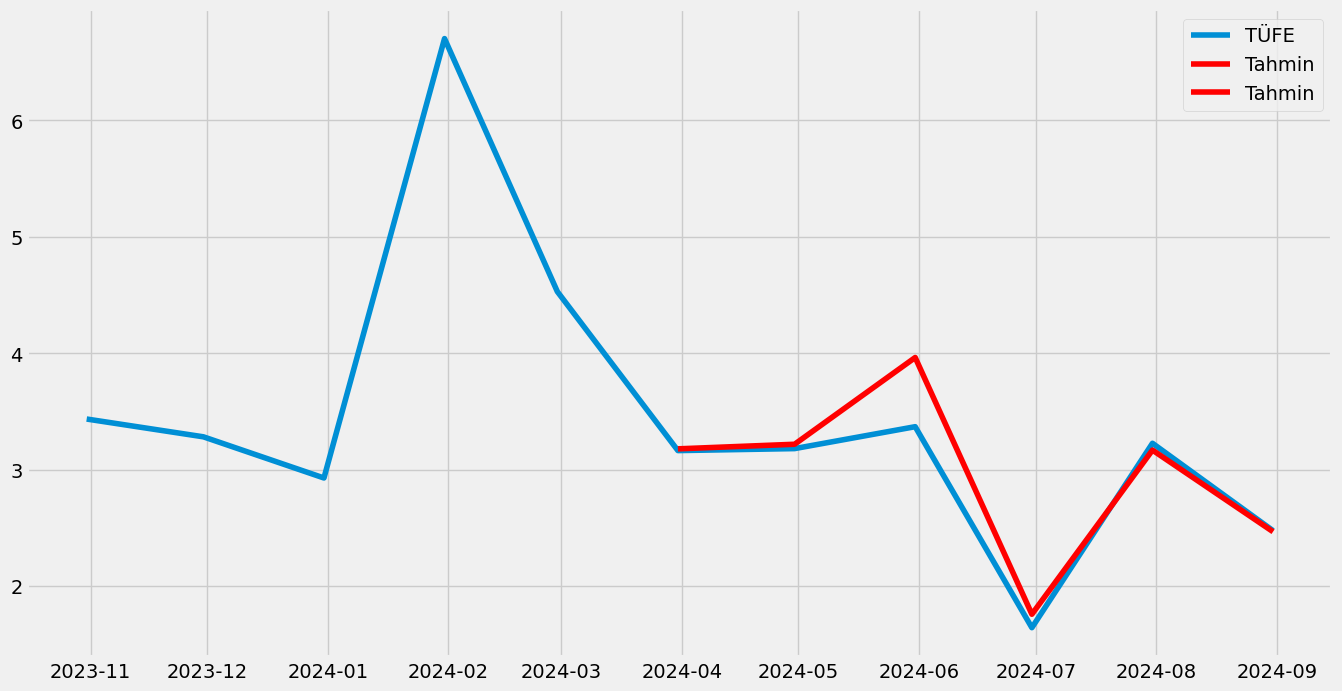

In [67]:
plt.figure(figsize=(15,8))
plt.plot(kısatahminler["TÜFE"].iloc[2:-1],label="TÜFE")
plt.plot(kısatahminler["Ortalama"].iloc[:8],label="Tahmin",color="red")
plt.plot(kısatahminler["Ensemble"].iloc[7:-1],label="Tahmin",color="red")
plt.legend()

## Orta Vadeli Tahminler

In [64]:
model=auto_arima(pfaiz["Faiz"],seasonal=False,information_criterion="bic")
model_fit = model.fit(pfaiz["Faiz"])
faiztahmin = model_fit.predict(25)
faiztahmin=pd.DataFrame(faiztahmin)
faiztahmin.columns=["Faiz"]
row=pd.DataFrame({"Faiz":pfaiz.iloc[-4:,0]},index=pd.date_range(start="2024-05-30",periods=4,freq="1M"))
faiztahmin=pd.concat([row,faiztahmin],axis=0)

faiztahmin.iloc[4:,0]=[50,50,50,50,50,50,50,50,50,50,50,45,40,35,35,35,35,30,30,30,30,30,25,25,25]
faiztahmin

,Faiz
2024-05-31,NaN
2024-06-30,50.106471
2024-07-31,50.000000
2024-08-31,50.337619
2024-10-31,50.000000
2024-11-30,50.000000
2024-12-31,50.000000
2025-01-31,50.000000
2025-02-28,50.000000
2025-03-31,50.000000


In [65]:
trainexog=pd.DataFrame()
trainexog["Dolar"]=usd.iloc[-16:-6,0].rolling(2).mean().dropna()*df14.iloc[:-6,0]
trainexog=trainexog.dropna()
trainexog=np.array(trainexog).reshape(-1,1)
testexog=pd.DataFrame()
testexog["Dolar"]=usd.iloc[-7:,0].rolling(2).mean().dropna()*df14.iloc[-6:,0]
testexog=testexog.dropna()
testexog=np.array(testexog).reshape(-1,1)

In [66]:
exog=pd.DataFrame()
exog["X"]=usd["USD/TL"].rolling(2).mean().dropna()*df14["Brent"]
exog=exog.dropna()
exog
#exog=np.array(exog).reshape(-1,1)


,X
2007-07-31,99.454046
2007-08-31,92.519699
2007-09-30,99.580871
2007-10-31,101.824103
2007-11-30,110.143119
...,...
2024-05-31,2679.695793
2024-06-30,2684.339030
2024-07-31,2738.228154
2024-08-31,2623.214664


In [67]:

zamtahmin=pd.DataFrame()
zamtahmin["Zam"]=[0,0,0,0,0,49.11,0,0,0,0,0,0,0,0,0,0,0,25,0,0,0,0,0,0,0,0,0,0,0,20]
zamtahmin.columns=["Zam"]
zamtahmin=zamtahmin.set_index(pd.date_range(start="2023-08-30",end="2026-02-27",freq="1M"))
zamtahmin

,Zam
2023-08-31,0.00
2023-09-30,0.00
2023-10-31,0.00
2023-11-30,0.00
2023-12-31,0.00
2024-01-31,49.11
2024-02-29,0.00
2024-03-31,0.00
2024-04-30,0.00
2024-05-31,0.00


In [68]:
faiztahmin.columns=["Faiz"]


In [69]:
exogtrain=pd.DataFrame()
exogtrain["Faiz"]=pfaiz["Faiz"].iloc[95:-13]
exogtrain=np.array(exogtrain).reshape(-1,1)

exogtest=pd.DataFrame()
exogtest=pd.concat([pfaiz["Faiz"].iloc[-14:-3],faiztahmin.iloc[2:,0]],axis=0)
exogtest=np.array(exogtest).reshape(-1,1)



In [74]:
exog=pfaiz["Faiz"].iloc[36:-2]
exog=np.array(exog).reshape(-1,1)

In [76]:
exogtest=faiztahmin.iloc[1:]
exogtest=np.array(exogtest).reshape(-1,1)

In [78]:
model=auto_arima(issizlik,seasonal=True,m=3,X=exog)
model_fit = model.fit(issizlik,X=exog)
issizliktahmin = model_fit.predict(28,X=exogtest)
issizliktahmin=pd.DataFrame(issizliktahmin)
issizliktahmin.columns=["İşsizlik"]
issizliktahmin

,İşsizlik
2024-08-31,8.799174
2024-09-30,8.800000
2024-10-31,8.797381
2024-11-30,8.800000
2024-12-31,8.800000
2025-01-31,8.800000
2025-02-28,8.800000
2025-03-31,8.800000
2025-04-30,8.800000
2025-05-31,8.800000


In [79]:
from prophet import Prophet

In [80]:
import optuna


In [81]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.01, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.50,0.99),
                'growth': trial.suggest_categorical('growth', ['linear']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,100),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"])

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=usd.index
    sn["y"]=usd.values
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"])
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=500,freq="D")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(usd.values,predictions["yhat"][:-500])
    return mae_score
try:
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=1000)
    print("Optimize işlemi başarıyla tamamlandı.")
except Exception as e:
    print(f'Hata oluştu: {e}')
    print('Optimize işlemi başarısız oldu. Devam ediyor...')
"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.01, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.50,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,100),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"])\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=usd.index\n    sn["y"]=usd.values\n    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],sea

In [82]:
"""study.best_params"""

'study.best_params'

In [83]:
sn=pd.DataFrame()
sn["ds"]=usd.index
sn["y"]=usd.values
prophet=Prophet(growth="linear",changepoint_prior_scale=8.828175414699565,changepoint_range=0.950080828826867,seasonality_prior_scale=7.816953755754968,n_changepoints=100,interval_width=0.70,yearly_seasonality=False,weekly_seasonality="auto")
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=500,freq="D")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

11:35:58 - cmdstanpy - INFO - Chain [1] start processing
11:35:58 - cmdstanpy - INFO - Chain [1] done processing


In [84]:
(predictions["yhat"].resample('M').mean().tail(19).pct_change()*100).dropna()

ds
2024-09-30    1.587815
2024-10-31    0.833598
2024-11-30    1.575910
2024-12-31    1.551461
2025-01-31    1.552803
2025-02-28    1.455073
2025-03-31    1.434204
2025-04-30    1.461856
2025-05-31    1.440793
2025-06-30    1.420329
2025-07-31    1.400438
2025-08-31    1.403738
2025-09-30    1.361978
2025-10-31    1.343678
2025-11-30    1.325862
2025-12-31    1.308513
2026-01-31    1.312786
2026-02-28    0.898683
Freq: ME, Name: yhat, dtype: float64

In [85]:
usdtahmin=(predictions["yhat"].resample('M').mean().tail(19).pct_change()*100).dropna()
usdtahmin

ds
2024-09-30    1.587815
2024-10-31    0.833598
2024-11-30    1.575910
2024-12-31    1.551461
2025-01-31    1.552803
2025-02-28    1.455073
2025-03-31    1.434204
2025-04-30    1.461856
2025-05-31    1.440793
2025-06-30    1.420329
2025-07-31    1.400438
2025-08-31    1.403738
2025-09-30    1.361978
2025-10-31    1.343678
2025-11-30    1.325862
2025-12-31    1.308513
2026-01-31    1.312786
2026-02-28    0.898683
Freq: ME, Name: yhat, dtype: float64

In [86]:
usd_aylık=usd.resample('M').mean().dropna()

In [87]:
usdtahmin1 = []
result = usd_aylık.iloc[-2,0]
for i in range(len(usdtahmin)):
    result *= (1 + usdtahmin[i] / 100)
    usdtahmin1.append(result)

usdtahmin1 = np.array(usdtahmin1).reshape(-1, 1)
usdtahmin1 = pd.DataFrame(usdtahmin1)
usdtahmin1.columns = ["USD/TL"]
usdtahmin1=pd.concat([usd_aylık["USD/TL"].loc["2024-03-31":"2024-08-31"],usdtahmin1],axis=0)
usdtahmin1 = usdtahmin1.set_index(pd.date_range(start="2024-03-31", periods=len(usdtahmin1), freq="1M"))
usdtahmin1

,USD/TL
2024-03-31,31.986743
2024-04-30,32.329467
2024-05-31,32.247882
2024-06-30,32.521235
2024-07-31,32.894495
2024-08-31,33.621248
2024-09-30,34.155091
2024-10-31,34.439807
2024-11-30,34.982547
2024-12-31,35.525288


In [88]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.001,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,100),
                'growth':trial.suggest_categorical('growth',['linear'])
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=df14[50:].index
    sn["y"]=df14[50:].values
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.001,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,100),\n                \'growth\':trial.suggest_categorical(\'growth\',[\'linear\'])\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=df14[50:].index\n    sn["y"]=df14[50:].values\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=13,freq="M")\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])\n    return mae_score\nstudy = optuna.create_study(direction=

In [89]:
"""study.best_params"""

'study.best_params'

In [90]:
sn=pd.DataFrame()
sn["ds"]=df14.index
sn["y"]=df14.values
prophet=Prophet(growth="linear",changepoint_prior_scale=10.333547662504625,changepoint_range=0.8962159367416,seasonality_prior_scale=2.378940289163559,n_changepoints=98)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

11:35:59 - cmdstanpy - INFO - Chain [1] start processing
11:35:59 - cmdstanpy - INFO - Chain [1] done processing


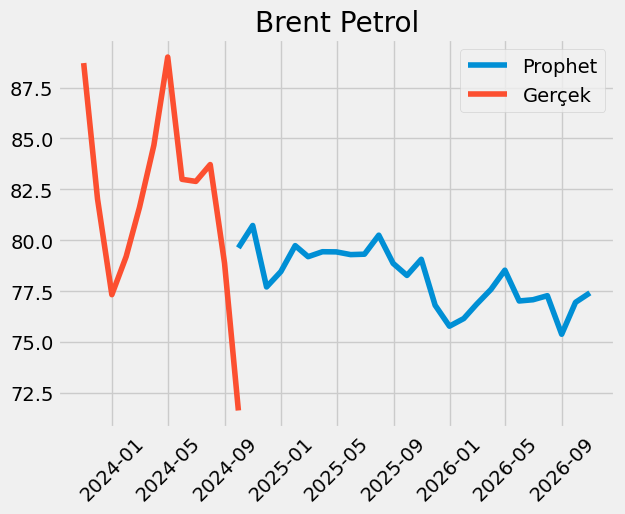

In [91]:
plt.title("Brent Petrol")
plt.plot(predictions["yhat"][-26:],label="Prophet")
plt.plot(df14["Brent"][-12:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [92]:
brenttahmin=predictions["yhat"][-29:]
brenttahmin

ds
2024-06-30    81.528536
2024-07-31    83.205476
2024-08-31    82.373229
2024-09-30    79.626796
2024-10-31    80.724297
2024-11-30    77.702926
2024-12-31    78.459933
2025-01-31    79.733197
2025-02-28    79.191227
2025-03-31    79.434422
2025-04-30    79.427050
2025-05-31    79.293261
2025-06-30    79.313447
2025-07-31    80.247934
2025-08-31    78.863377
2025-09-30    78.269657
2025-10-31    79.063693
2025-11-30    76.804510
2025-12-31    75.776016
2026-01-31    76.152113
2026-02-28    76.859857
2026-03-31    77.586946
2026-04-30    78.527651
2026-05-31    77.015113
2026-06-30    77.075861
2026-07-31    77.274750
2026-08-31    75.380546
2026-09-30    76.948574
2026-10-31    77.412813
Name: yhat, dtype: float64

In [93]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.001,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,50),
                'growth':trial.suggest_categorical('growth',['linear'])

            

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=enf_belirsizlik.index
    sn["y"]=enf_belirsizlik.values
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.001,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,50),\n                \'growth\':trial.suggest_categorical(\'growth\',[\'linear\'])\n\n            \n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=enf_belirsizlik.index\n    sn["y"]=enf_belirsizlik.values\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=13,freq="M")\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])\n    return mae_score\nstudy = o

11:36:00 - cmdstanpy - INFO - Chain [1] start processing
11:36:00 - cmdstanpy - INFO - Chain [1] done processing


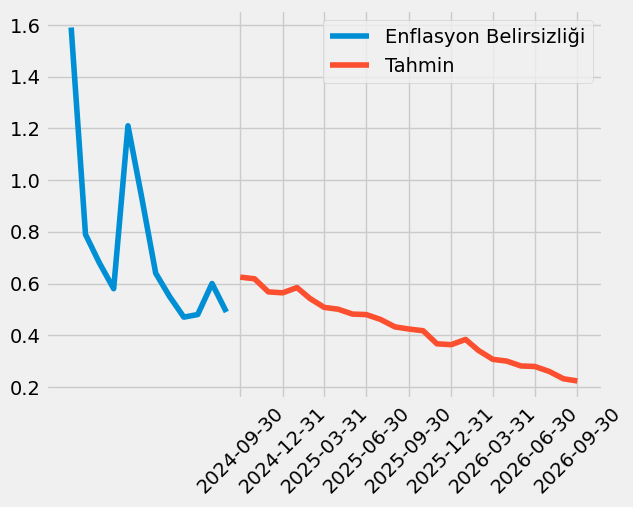

In [94]:
sn=pd.DataFrame()
sn["ds"]=enf_belirsizlik.index
sn["y"]=enf_belirsizlik.values
prophet=Prophet(changepoint_prior_scale=10,changepoint_range=0.78,seasonality_prior_scale=0.003403857042852,n_changepoints=6,growth="linear")
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])
plt.plot(enf_belirsizlik[-12:],label="Enflasyon Belirsizliği")
plt.plot(predictions["yhat"][-25:],label="Tahmin")
plt.xticks(predictions.index[-25::3],rotation=45)
plt.legend()

In [95]:
enfbelirsizliktahmin1=pd.DataFrame(predictions["yhat"][-26:])
enfbelirsizliktahmin1.columns=["Enflasyon Belirsizliği"]
enfbelirsizliktahmin1.index.names=[""]
enfbelirsizliktahmin1.iloc[0,0]=enf_belirsizlik.iloc[-1,0]
enfbelirsizliktahmin1

,Enflasyon Belirsizliği
,
2024-08-31,0.490000
2024-09-30,0.624669
2024-10-31,0.618326
2024-11-30,0.567635
2024-12-31,0.564012
2025-01-31,0.584331
2025-02-28,0.542046
2025-03-31,0.507578
2025-04-30,0.500697


In [96]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',[0.01,10]),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'm':trial.suggest_int('m',0,110),
                'cap':trial.suggest_float('cap',0,200)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][params["m"]:-12].index
    sn["y"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][params["m"]:-12].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][-12:],predictions["yhat"].tail(12))
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',[0.01,10]),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'m\':trial.suggest_int(\'m\',0,110),\n                \'cap\':trial.suggest_float(\'cap\',0,200)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][p

In [97]:
#study.best_params

In [98]:
brenttahmin1=(brenttahmin.pct_change()*100).dropna()
brenttahmin1

ds
2024-07-31    2.056875
2024-08-31   -1.000231
2024-09-30   -3.334133
2024-10-31    1.378306
2024-11-30   -3.742828
2024-12-31    0.974233
2025-01-31    1.622820
2025-02-28   -0.679729
2025-03-31    0.307099
2025-04-30   -0.009281
2025-05-31   -0.168442
2025-06-30    0.025458
2025-07-31    1.178220
2025-08-31   -1.725349
2025-09-30   -0.752845
2025-10-31    1.014487
2025-11-30   -2.857421
2025-12-31   -1.339106
2026-01-31    0.496327
2026-02-28    0.929382
2026-03-31    0.945994
2026-04-30    1.212453
2026-05-31   -1.926122
2026-06-30    0.078879
2026-07-31    0.258043
2026-08-31   -2.451259
2026-09-30    2.080148
2026-10-31    0.603312
Name: yhat, dtype: float64

In [99]:
motorintahmin=pd.DataFrame((1+(((usdtahmin1[3:].pct_change(periods=1)*100).dropna())/100)).values*(1+(((brenttahmin1[:-8]).dropna())/100)).values.reshape(-1,1))
motorintahmin.columns=["Motorin"]
motorintahmin=motorintahmin.set_index(pd.date_range(start="2024-07-30",periods=len(motorintahmin),freq="1M"))
motorintahmin=(motorintahmin-1)*100
motorintahmin

,Motorin
2024-07-31,3.228226
2024-08-31,1.187013
2024-09-30,-1.799258
2024-10-31,2.223394
2024-11-30,-2.225901
2024-12-31,2.540808
2025-01-31,3.200823
2025-02-28,0.765453
2025-03-31,1.745708
2025-04-30,1.452438


In [100]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,100),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=money["Para Arzi"].index
    sn["y"]=money["Para Arzi"].values
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(money["Para Arzi"],predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,100),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=money["Para Arzi"].index\n    sn["y"]=money["Para Arzi"].values\n    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_rang

In [101]:
sn=pd.DataFrame()
sn["ds"]=money["Para Arzi"].index
sn["y"]=money["Para Arzi"].values
prophet=Prophet(changepoint_prior_scale=0.904897796889,changepoint_range=0.9529543315216538,growth='linear',seasonality_prior_scale=3.03031163229546,n_changepoints=15)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

11:36:01 - cmdstanpy - INFO - Chain [1] start processing
11:36:01 - cmdstanpy - INFO - Chain [1] done processing


In [102]:
paraarzitahmin=(predictions["yhat"]).tail(26)
paraarzitahmin

ds
2024-08-31    2.442246
2024-09-30    3.618864
2024-10-31    3.495575
2024-11-30    3.185466
2024-12-31    3.264609
2025-01-31    1.840395
2025-02-28    2.189803
2025-03-31    3.896750
2025-04-30    3.441596
2025-05-31    3.041132
2025-06-30    3.448107
2025-07-31    2.625094
2025-08-31    2.847593
2025-09-30    2.879326
2025-10-31    2.617592
2025-11-30    2.598064
2025-12-31    3.311157
2026-01-31    1.456267
2026-02-28    2.054899
2026-03-31    3.466347
2026-04-30    2.440432
2026-05-31    2.683272
2026-06-30    3.334919
2026-07-31    2.057706
2026-08-31    3.247142
2026-09-30    2.121298
Name: yhat, dtype: float64

In [103]:
paraarzitahmin1 = paraarzitahmin
paraarzitahmin1 = np.array(paraarzitahmin1).reshape(-1, 1)
paraarzitahmin1 = pd.DataFrame(paraarzitahmin1)
paraarzitahmin1.columns = ["Para Arzi"]
paraarzitahmin1 = paraarzitahmin1.set_index(pd.date_range(start="2024-09-30", periods=len(paraarzitahmin), freq="1M"))
row=pd.DataFrame({"Para Arzi":money.iloc[-6:,0]},index=pd.date_range(start="2024-03-31",periods=6,freq="M"))
paraarzitahmin1=pd.concat([row,paraarzitahmin1])
np.cumprod(1+(paraarzitahmin1.loc["2024-01-31":"2024-12-31"])/100)

,Para Arzi
2024-03-31,1.023967
2024-04-30,1.044264
2024-05-31,1.063682
2024-06-30,1.096514
2024-07-31,1.123503
2024-08-31,1.166228
2024-09-30,1.194710
2024-10-31,1.237945
2024-11-30,1.281218
2024-12-31,1.322031


In [104]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'm':trial.suggest_int('m',0,110),
                'cap':trial.suggest_float('cap',0,200)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=borc["Borç"][params["m"]:-12].index
    sn["y"]=borc["Borç"][params["m"]:-12].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(borc["Borç"][-12:],predictions["yhat"][-12:])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'m\':trial.suggest_int(\'m\',0,110),\n                \'cap\':trial.suggest_float(\'cap\',0,200)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=borc["Borç"][params["m"]:-12].index\n    sn["y"]=borc["Borç

In [105]:
#study.best_params

In [106]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,5),
                'n_changepoints':trial.suggest_int('n_changepoints',1,200),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),


                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=df3["Kredi"].index
    sn["y"]=df3["Kredi"].values
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(df3.values,predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,5),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,200),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=df3["Kredi"].index\n    sn["y"]=df3["Kredi"].values\n    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=

In [107]:
"""study.best_params"""

'study.best_params'

In [108]:
sn=pd.DataFrame()
sn["ds"]=kredi["Kredi"].index
sn["y"]=kredi["Kredi"].values
prophet=Prophet(changepoint_prior_scale=0.01099759561372614,changepoint_range=0.0589785485153,growth="linear",seasonality_prior_scale=0.04157847860739,n_changepoints=10,yearly_seasonality=True,weekly_seasonality=True)

prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

11:36:02 - cmdstanpy - INFO - Chain [1] start processing
11:36:02 - cmdstanpy - INFO - Chain [1] done processing


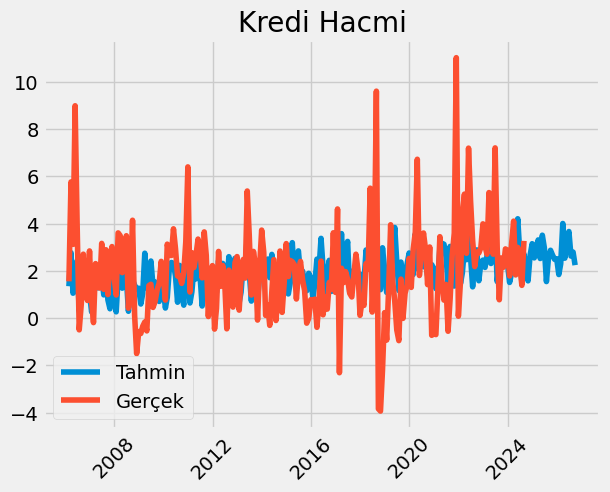

In [109]:
plt.title("Kredi Hacmi")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(kredi["Kredi"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [110]:
kreditahmin=(predictions["yhat"]).tail(26)
kreditahmin

ds
2024-08-31    2.720773
2024-09-30    2.183628
2024-10-31    1.580379
2024-11-30    2.651305
2024-12-31    3.153810
2025-01-31    2.552347
2025-02-28    2.992657
2025-03-31    3.313926
2025-04-30    2.526220
2025-05-31    3.514033
2025-06-30    2.984232
2025-07-31    1.550654
2025-08-31    2.567515
2025-09-30    2.875387
2025-10-31    2.661401
2025-11-30    2.490838
2025-12-31    2.517762
2026-01-31    1.847741
2026-02-28    2.300134
2026-03-31    4.008981
2026-04-30    2.539489
2026-05-31    3.352531
2026-06-30    3.669798
2026-07-31    2.628862
2026-08-31    2.798004
2026-09-30    2.245491
Name: yhat, dtype: float64

In [111]:
kreditahmin1 = kreditahmin

kreditahmin1 = np.array(kreditahmin1).reshape(-1, 1)
kreditahmin1 = pd.DataFrame(kreditahmin1)
kreditahmin1.columns = ["Kredi"]
kreditahmin1 = kreditahmin1.set_index(pd.date_range(start="2024-09-30", periods=len(kreditahmin1), freq="1M"))
row=pd.DataFrame({"Kredi":kredi.iloc[-4:,0]},index=pd.date_range(start="2024-05-30",periods=4,freq="1M"))
kreditahmin1=pd.concat([row,kreditahmin1],axis=0)
kreditahmin1

,Kredi
2024-05-31,2.996833
2024-06-30,2.281882
2024-07-31,1.391026
2024-08-31,3.273129
2024-09-30,2.720773
2024-10-31,2.183628
2024-11-30,1.580379
2024-12-31,2.651305
2025-01-31,3.153810
2025-02-28,2.552347


In [112]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,150),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=m3["M3"].index
    sn["y"]=m3["M3"].values
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(m3["M3"],predictions["yhat"][:-12])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,150),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=m3["M3"].index\n    sn["y"]=m3["M3"].values\n    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["

In [113]:
sn=pd.DataFrame()
sn["ds"]=m3["M3"].index
sn["y"]=m3["M3"].values
prophet=Prophet(changepoint_prior_scale=2.5,changepoint_range=0.9,growth='linear',seasonality_prior_scale=4.7636997959024185,n_changepoints=10)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=18,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

11:36:02 - cmdstanpy - INFO - Chain [1] start processing
11:36:02 - cmdstanpy - INFO - Chain [1] done processing


In [114]:
m3tahmin=(predictions["yhat"].tail(18))


m3tahmin1 = np.array(m3tahmin).reshape(-1, 1)
m3tahmin1 = pd.DataFrame(m3tahmin1)
m3tahmin1.columns = ["M3"]
m3tahmin1 = m3tahmin1.set_index(pd.date_range(start="2024-09-30", periods=len(m3tahmin1), freq="1M"))
row=pd.DataFrame({"M3":m3.iloc[-4:,0]},index=pd.date_range(start="2024-05-30",periods=4,freq="1M"))
m3tahmin1=pd.concat([row,m3tahmin1],axis=0)
m3tahmin1

,M3
2024-05-31,3.570039
2024-06-30,3.132936
2024-07-31,3.040594
2024-08-31,3.971451
2024-09-30,3.408045
2024-10-31,3.604251
2024-11-30,3.215123
2024-12-31,2.492286
2025-01-31,1.545808
2025-02-28,2.047107


In [115]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'cap':trial.suggest_float('cap',0,400)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=sanayi["Sanayi"].index
    sn["y"]=sanayi["Sanayi"].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=15,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sanayi["Sanayi"],predictions["yhat"][:-15])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'cap\':trial.suggest_float(\'cap\',0,400)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=sanayi["Sanayi"].index\n    sn["y"]=sanayi["Sanayi"].values\n    sn["cap"]=params["cap"]\n    prophet=Prophet(cha

In [116]:
#study.best_params

In [117]:
"""def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,50),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'cap':trial.suggest_int('cap',0,400)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=redkt["REDKT"].index
    sn["y"]=redkt["REDKT"].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=36,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(redkt["REDKT"],predictions["yhat"][:-36])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,50),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'cap\':trial.suggest_int(\'cap\',0,400)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=redkt["REDKT"].index\n    sn["y"]=redkt["REDKT"].values\n    sn["cap"]=params["cap"]\n    prophet=Prophet(changepoint_prior_scal

In [118]:
import statsmodels.api as sm
tahmindf=pd.DataFrame()
tahmindf=pd.concat([usdtahmin1["USD/TL"].rolling(3).mean()],axis=1)

tahmindf=tahmindf.pct_change(periods=1)*100
tahmindf["M3"]=m3tahmin1["M3"].shift(1)
tahmindf["Para Arzi"]=paraarzitahmin1.rolling(3).mean()
tahmindf["Enflasyon Belirsizliği"]=enfbelirsizliktahmin1["Enflasyon Belirsizliği"]
tahmindf["Kredi"]=kreditahmin1["Kredi"].shift(1).rolling(2).mean()
tahmindf["Kredi2"]=kreditahmin1["Kredi"].rolling(3).mean()
tahmindf["Zam"]=zamtahmin["Zam"]
tahmindf["Motorin"]=motorintahmin["Motorin"].rolling(2).mean()
tahmindf["Motorin2"]=motorintahmin["Motorin"]
tahmindf["İşsizlik"]=issizliktahmin





tahmindf=tahmindf[['USD/TL', 'Motorin','Motorin2', 'Zam',
       'Enflasyon Belirsizliği', 'Para Arzi', 'M3', 'Kredi','Kredi2','İşsizlik']]

tahmindf.columns=["USD/TL","Motorin","Motorin2","Zam","Enflasyon Belirsizliği",'ParaArzi','M3', 'Kredi','Kredi2','İşsizlik']
tahmindf=tahmindf.loc["2024-09-30":]


tahmindf=tahmindf.loc["2024-08-31":]
tahmindf["Motorin"].iloc[0]=data["Motorin"].iloc[-1]
tahmindf["ParaArzi"].iloc[0]=data["ParaArzi"].iloc[-1]
tahmindf["M3"].iloc[0]=data["M3"].iloc[-1]
tahmindf["Kredi"].iloc[0]=data["Kredi"].iloc[-1]
tahmindf["Enflasyon Belirsizliği"].iloc[0]=data["Enflasyon Belirsizliği"].iloc[-1]
tahmindf["Zam"].iloc[-1]=0
tahmindf

,USD/TL,Motorin,Motorin2,Zam,Enflasyon Belirsizliği,ParaArzi,M3,Kredi,Kredi2,İşsizlik
2024-09-30,1.649743,-2.370000,-1.799258,0.0,0.490000,1.806600,2.070000,2.332000,2.461643,8.800000
2024-10-31,1.535014,0.212068,2.223394,0.0,0.618326,3.287985,3.408045,2.996951,2.725843,8.797381
2024-11-30,1.331785,-0.001253,-2.225901,0.0,0.567635,3.185562,3.604251,2.452201,2.161593,8.800000
2024-12-31,1.322872,0.157454,2.540808,0.0,0.564012,3.433302,3.215123,1.882004,2.138437,8.800000
2025-01-31,1.559938,2.870816,3.200823,25.0,0.584331,3.315217,2.492286,2.115842,2.461831,8.800000
2025-02-28,1.519283,1.983138,0.765453,0.0,0.542046,2.763490,1.545808,2.902557,2.785820,8.800000
2025-03-31,1.480100,1.255580,1.745708,0.0,0.507578,2.431603,2.047107,2.853078,2.899604,8.800000
2025-04-30,1.450410,1.599073,1.452438,0.0,0.500697,2.642316,3.486163,2.772502,2.952977,8.800000
2025-05-31,1.445648,1.361181,1.269924,0.0,0.481830,3.176050,3.054228,3.153292,2.944268,8.800000
2025-06-30,1.440793,1.358036,1.446148,0.0,0.479847,3.459826,2.947628,2.920073,3.118060,8.800000


In [119]:
features=['USD/TL', 'Motorin', 'M3', 'Enflasyon Belirsizliği', 'TÜFEt-1', 'Kredi', 'İhracat', 'İthalat',
       'İşsizlik', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1', 'TÜFECt1','Anket','ParaArzi','Zam', 'TÜFE']

data1=data[features]
from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
scaled_data

,USD/TL,Motorin,M3,Enflasyon Belirsizliği,TÜFEt-1,Kredi,İhracat,İthalat,İşsizlik,ÜFEt2,TÜFECt2,ÜFEt1,TÜFECt1,Anket,ParaArzi,Zam,TÜFE
0,0.239862,0.042052,-0.268959,-0.553349,0.037740,0.795636,-0.562768,-1.368187,-0.987149,-0.385268,-0.898194,0.364605,-0.713312,-0.653956,-0.230828,-0.286359,-0.657717
1,0.068549,-0.367038,-0.795998,-0.938986,-0.655187,-0.291229,0.283711,-0.645125,-0.987149,0.365235,-0.700480,-0.292044,-0.528106,-0.683832,-0.693304,-0.286359,-0.346209
2,-1.081334,-0.993370,-1.199030,-0.759022,-0.343385,-0.962807,0.858549,1.092309,-0.856752,-0.291254,-0.515641,-0.511703,-0.294051,-0.601672,-1.082052,-0.286359,-0.248228
3,-1.236741,-0.857285,-1.343329,-0.681894,-0.245312,-1.089700,-0.694908,-0.008061,-0.856752,-0.510859,-0.282049,-0.732472,0.140697,-0.698771,-1.299530,-0.286359,-0.672443
4,-1.154087,-0.146616,-0.952997,-0.527640,-0.669926,-0.918881,0.039103,-0.044329,-0.856752,-0.731575,0.151836,-0.938215,-0.149935,-1.005004,-0.949565,-0.286359,-0.710156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,-0.203117,-0.461696,0.332374,-0.142003,0.574990,0.619349,-1.212762,-0.291290,-1.639136,0.357021,0.813075,0.460803,0.821061,1.101286,-0.121979,-0.286359,0.655410
124,-0.508510,-0.555433,0.419801,-0.116294,0.659178,0.284752,1.826607,0.382526,-1.182745,0.461410,0.830852,-0.097241,0.914546,0.712892,0.001776,-0.286359,-0.116104
125,-0.499939,0.425895,0.544634,0.192216,-0.113063,0.420115,-1.713409,-1.736647,-1.443540,-0.096498,0.924151,-0.294538,-0.044313,0.899620,0.087714,-0.286359,0.591757
126,-0.251190,0.268869,0.623479,-0.090585,0.595465,-0.063144,1.514496,1.618155,-1.704335,-0.102561,-0.032807,-0.102770,0.298339,0.735299,0.436287,-0.286359,0.256252


In [120]:
"""import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,GRU,SimpleRNN
import keras
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import l2,l1
features=['M3','ParaArzi','Enflasyon Belirsizliği','Kredi','İşsizlik']
def weighted_mse(y_true, y_pred):
    n = len(y_true)
    weights = 1 / np.arange(1, n + 1)  # Ters orantılı ağırlıklar
    weights = weights[::-1]  # Ağırlıkları ters çevir (küçükten büyüğe)
    mse = np.sum(weights * (y_true - y_pred) ** 2) / n
    return mse
def objective(trial):
    # Define hyperparameters to be optimized
    selected_features = ["USD/TL","Motorin","Zam"]
    for feature in features:
        if trial.suggest_categorical(feature, (True, False)):
            selected_features.append(feature)

    if len(selected_features) == 0:
        return float('inf')  # Hiçbir özellik seçilmezse, bu deneme geçersiz sayılır
    
    X=scaled_data[selected_features]
    y=scaled_data["TÜFE"]
    X=np.array(X)
    y=np.array(y).reshape(-1,1)
    X=pd.DataFrame(X,columns=selected_features)
    y=pd.DataFrame(y,columns=["TÜFE"])
    X_train,X_test=X.iloc[:-7,:],X.iloc[-7:,:]
    y_train,y_test=y[:-7],y[-7:]
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)


    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1)
    units1 = trial.suggest_int('units1', 1, 256)
    batch_size = trial.suggest_int('batch_size', 2, 64)
    activation1 = trial.suggest_categorical('activation1', ['tanh','selu','relu','linear'])
    optimizer = trial.suggest_categorical('optimizer', ['adam'])
    rlrate=trial.suggest_float('rlrate',0.001,0.999)
    keras.utils.set_random_seed(42)
    early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
    model = Sequential()   
    model.add(Dense(units=units1,activation=activation1,input_dim=(X_train.shape[1]),kernel_regularizer=l2(rlrate)))
    model.add(Dense(units=1))

    if optimizer == 'adam':
       optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
       optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == 'SGD':
       optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate) 

    

    

    

    model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])

    # Train model
    model.fit(X_train, y_train, epochs=1000, batch_size=batch_size,callbacks=[early_stopping],verbose=0,validation_data=(X_val,y_val))

    # Evaluate model
    y_pred = model.predict(X_test)
    tahminler=pd.DataFrame(scaler2.inverse_transform(y_test))
    tahminler.columns=["TÜFE"]
    tahminler["Tahmin"]=scaler2.inverse_transform(y_pred)
    tahminler=tahminler.set_index(data.index[-7:])
    tahminler.loc["2024-05-31","Tahmin"]+=0.66
    tahminler.loc["2024-07-31","Tahmin"]+=0.67
    mse=mean_squared_error(tahminler["TÜFE"].iloc[:-1],tahminler["Tahmin"].iloc[:-1])


    return mse # Return validation accuracy as the objective

study = optuna.create_study(direction='minimize')  # or 'minimize' depending on your objective
study.optimize(objective, n_trials=2000)  # You can adjust the number of trials

# Print the best hyperparameters
print('Best hyperparameters:', study.best_params)"""

'import optuna\nimport tensorflow as tf\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import LSTM, Dense,GRU,SimpleRNN\nimport keras\nfrom keras.callbacks import EarlyStopping\nfrom keras import regularizers\nfrom keras.layers import LSTM, Dense, Dropout\nfrom keras.regularizers import l2,l1\nfeatures=[\'M3\',\'ParaArzi\',\'Enflasyon Belirsizliği\',\'Kredi\',\'İşsizlik\']\ndef weighted_mse(y_true, y_pred):\n    n = len(y_true)\n    weights = 1 / np.arange(1, n + 1)  # Ters orantılı ağırlıklar\n    weights = weights[::-1]  # Ağırlıkları ters çevir (küçükten büyüğe)\n    mse = np.sum(weights * (y_true - y_pred) ** 2) / n\n    return mse\ndef objective(trial):\n    # Define hyperparameters to be optimized\n    selected_features = ["USD/TL","Motorin","Zam"]\n    for feature in features:\n        if trial.suggest_categorical(feature, (True, False)):\n            selected_features.append(feature)\n\n    if len(selected_features) == 0:\n        return float(\'i

In [121]:
trials=pd.read_excel("futuretrial2.xlsx")
del trials["Unnamed: 0"]
predictions=pd.DataFrame()
for i in range(10):
    features=['USD/TL', 'Motorin2', 'M3', 'Enflasyon Belirsizliği', 'TÜFEt-1', 'Kredi', 'İhracat', 'İthalat',
       'İşsizlik', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1', 'TÜFECt1','Anket','ParaArzi','Zam', 'TÜFE']

    data1=data[features]
    from sklearn.preprocessing import StandardScaler
    scaler1 = StandardScaler()
    scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
    scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
    scaler2 = StandardScaler()
    scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
    trial=trials.iloc[i:i+1,:]
    true_columns = trial.columns[trial.any()]
    cleaned_column_names = [name.replace('params_', '') if name.startswith('params_') else name for name in true_columns]
    columns_to_drop = [
        'number', 'value', 'datetime_start', 'datetime_complete', 'duration',
        'activation1', 'batch_size', 'learning_rate', 'optimizer', 'rlrate', 
        'units1', 'state'
    ]


    features = [col for col in cleaned_column_names if col not in columns_to_drop]
    features.append("USD/TL")
    features.append("Motorin2")
    features.append("Zam")



    units=int(trial["params_units1"].values[0])
    activation=trial["params_activation1"].values[0]
    rl=trial["params_rlrate"].values[0]
    lr=trial["params_learning_rate"].values[0]
    batch=int(trial["params_batch_size"].values[0])
    X=scaled_data[features]
    y=scaled_data["TÜFE"]
    X=np.array(X)
    y=np.array(y).reshape(-1,1)
    X=pd.DataFrame(X,columns=features)
    y=pd.DataFrame(y,columns=["TÜFE"])
    X_train,X_test=X.iloc[:-7,:],X.iloc[-7:,:]
    y_train,y_test=y[:-7],y[-7:]
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
    keras.utils.set_random_seed(42)
    early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
    model = Sequential()   
    model.add(Dense(units=units,activation=activation,input_dim=(X_train.shape[1]),kernel_regularizer=l2(rl)))
    model.add(Dense(units=1))
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
    history=model.fit(X_train, y_train, epochs=1000, batch_size=batch,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))

    features.append("TÜFE")
    data1=pd.concat([data,tahmindf],axis=0)
    data1=data1[features]
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data1.iloc[:,:-1])
    scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
    scaler = StandardScaler()
    scaled_data["TÜFE"]=scaler.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))

    X=scaled_data.iloc[:,:-1]
    y=scaled_data["TÜFE"]
    X=np.array(X)
    y=np.array(y).reshape(-1,1)
    X=pd.DataFrame(X,columns=scaled_data.columns[:-1])
    y=pd.DataFrame(y,columns=["TÜFE"])
    X_test=scaled_data.iloc[-len(tahmindf):,:-1]


    pred=scaler.inverse_transform(model.predict(np.array(X_test)))
    pred=pd.DataFrame(pred)
    pred.columns=["TÜFE"]
    pred=pred.set_index(pd.date_range(start="2024-09-30",periods=len(tahmindf),freq="1M"))
    pred.iloc[0]=kısatahminler["Ensemble"].iloc[-1]
    predictions=pd.concat([predictions,pred["TÜFE"]],axis=1)

Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - loss: 10.1180 - mean_squared_error: 2.7260 - val_loss: 3.3265 - val_mean_squared_error: 1.5175
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.3842 - mean_squared_error: 2.7376 - val_loss: 2.3867 - val_mean_squared_error: 0.5268
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 3.0599 - mean_squared_error: 1.2069 - val_loss: 2.1033 - val_mean_squared_error: 0.5445
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2.5015 - mean_squared_error: 1.0462 - val_loss: 1.3930 - val_mean_squared_error: 0.4383
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.3445 - mean_squared_error: 0.4137 - val_loss: 0.9486 - val_mean_squared_error: 0.0913
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.1128 - mean_squared_error: 0.3011 - val_loss: 1.0241 - val_mean_squared_error: 0.4256
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step - loss: 10.0224 - mean_squ

In [122]:
predictions=predictions.iloc[:,[0,1,2,6,7,8,9]]

In [123]:
def create_tüfe(data):
    tüfetahmin = []
    result = enf["TÜFE"].iloc[-1]
    pred=np.array(data.values).reshape(1,-1).ravel()
    for i in range(len(pred)):
        result *= (1 + (pred[i] / 100))
        tüfetahmin.append(result)
    tüfetahmin[0]=enf["TÜFE"].iloc[-1]*(1+(data[0]/100))

    tüfetahmin = np.array(tüfetahmin).reshape(-1, 1)
    tüfetahmin = pd.DataFrame(tüfetahmin)
    tüfetahmin = tüfetahmin.set_index(pd.date_range(start="2024-09-30", periods=len(tüfetahmin), freq="1M"))
    return tüfetahmin


In [124]:
tüfetahmin_dict={}
for i in range(len(predictions.columns)):
    # Dinamik olarak bir sözlük içinde tahminleri saklıyoruz.
    tüfetahmin_dict[f"tüfetahmin_{i}"] = create_tüfe(predictions.iloc[:, i])
    # Kolon adını güncelleme
    tüfetahmin_dict[f"tüfetahmin_{i}"].columns = [f"NN_{i}"]




In [125]:
tüfetahmin=pd.concat(tüfetahmin_dict.values(), axis=1)


In [126]:
std=tüfetahmin.std(axis=1)

In [127]:
predictions.columns=tüfetahmin.columns

In [128]:
dates=pd.date_range('2006-02-28','2024-03-28' , freq='1M')
df=pd.DataFrame()

df["CPI"]=enf["TÜFE"]
df=df.set_index(pd.to_datetime(enf.index))




dfas1=pd.DataFrame()
dfas1=pd.concat([df["CPI"],tüfetahmin.mean(axis=1)],axis=0)
dfas1=pd.DataFrame(dfas1)
dfas1.columns=["Ortalama"]


dfas2=pd.DataFrame()
dfas2=pd.concat([df["CPI"],tüfetahmin.max(axis=1)],axis=0)
dfas2=pd.DataFrame(dfas2)
dfas2.columns=["Max"]

dfas2["Max"].loc["2024-09-30":"2024-12-31"]+=(std.loc["2024-09-30":"2024-12-31"])/2
dfas3=pd.DataFrame()
dfas3=pd.concat([df["CPI"],tüfetahmin.min(axis=1)],axis=0)
dfas3=pd.DataFrame(dfas3)
dfas3.columns=["Min"]

dfas0=pd.DataFrame()
for i in range(tüfetahmin.shape[1]):
    dfas00=pd.DataFrame()
    dfas00=pd.concat([df["CPI"],tüfetahmin.iloc[:,i]],axis=0)
    dfas00=pd.DataFrame(dfas00)
    dfas00.columns=[f"NN_{i}"]
    dfas0=pd.concat([dfas0,dfas00],axis=1)



dfas=pd.DataFrame()
dfas=pd.concat([dfas1,dfas0],axis=1)
dfas=dfas.dropna(axis=0)
dfas=dfas.drop("NN_1",axis=1)
dfas["Ortalama"]=dfas.mean(axis=1)
dfas["Max"]=dfas2["Max"]
dfas["Min"]=dfas3["Min"]
dfas=dfas.pct_change(periods=12)*100
df["Enflasyon"]=df["CPI"].pct_change(periods=12)*100
df=df.dropna(axis=0)







In [129]:
predictions=predictions[dfas.columns[1:-2]]
predictions["Ortalama"]=predictions.mean(axis=1)

In [130]:
std=predictions.iloc[:,:-1].std(axis=1)

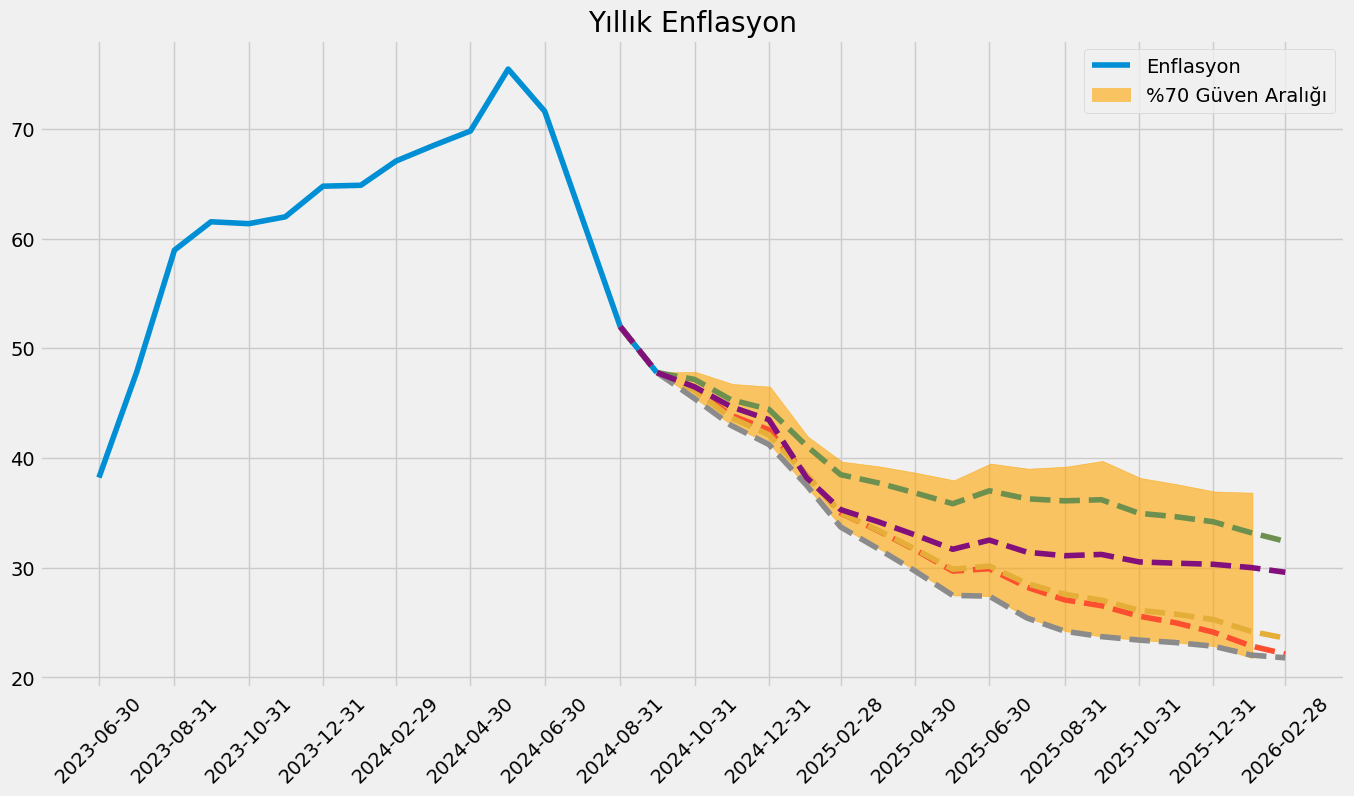

In [131]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(15,8))
plt.plot(dfas["Ortalama"].loc["2023-06-30":"2024-09-30"],label="Enflasyon")
plt.plot(dfas.iloc[:,1:-3].loc["2024-08-30":],'--')
plt.fill_between(dfas.loc["2024-08-30":].index.strftime("%Y-%m"), dfas["Max"].loc["2024-08-30":].shift(1), dfas["Min"].loc["2024-08-30":].shift(1), alpha=0.6, color='orange',label="%70 Güven Aralığı")
plt.legend(loc=0)
plt.xticks(dfas.loc["2023-06-30":].index[::2],rotation=45)
plt.title("Yıllık Enflasyon")
plt.show()

In [132]:
sonu12024=str(dfas["Ortalama"].loc["2024-12-31"])[:5]
min2024=str(dfas["Min"].loc["2024-12-31"])[:5]
max2024=str(dfas["Max"].loc["2024-12-31"])[:5]

In [133]:
params = {
    'series': "TP.PKAUO.S01.D.U",
    'startDate': "01-08-2024",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

ay12sonra = formatted_response['items']
ay12sonra = pd.DataFrame(ay12sonra)


ay12sonra = ay12sonra.drop(columns=['UNIXTIME','Tarih'])
ay12sonra.columns = ['Beklenti']
ay12sonra['Beklenti'] = pd.to_numeric(ay12sonra['Beklenti'])
ay12sonra=ay12sonra.set_index(pd.date_range(start="2024-08-01",freq="M",periods=len(ay12sonra)))
ay12sonra=ay12sonra.dropna()
ay12sonra

,Beklenti
2024-08-31,43.31


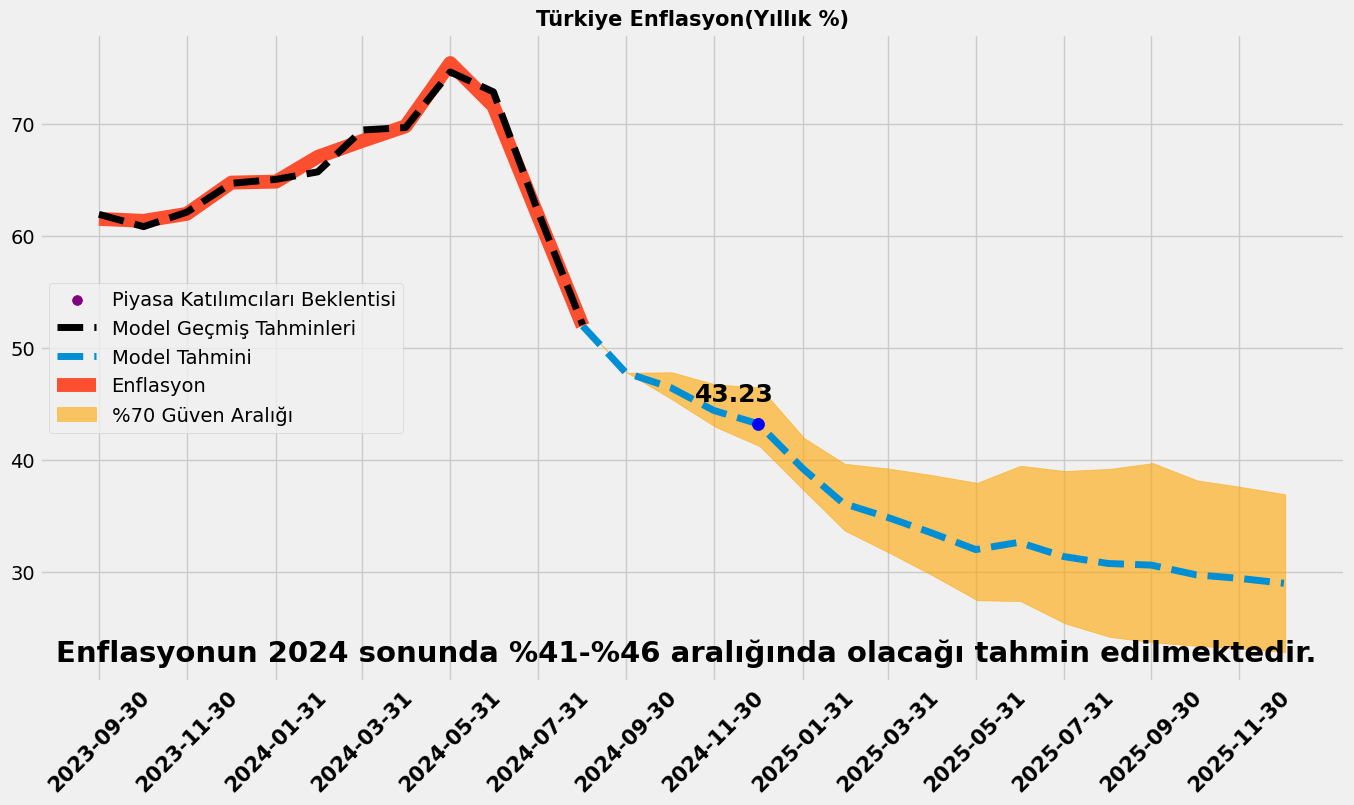

In [134]:
import matplotlib.dates as mdates
plt.style.use('fivethirtyeight')
fig=plt.figure(figsize=(15,8))
plt.scatter(x=pd.to_datetime("2024-12-31"),y=ay12sonra["Beklenti"].values,color="purple",zorder=3,s=50,label="Piyasa Katılımcıları Beklentisi")
geçmiş=pd.DataFrame({"Tahmin":[61.94,60.84,62.13,64.71,65.06,65.73,69.47,69.69,74.65,72.87,62.17,52.07]})
geçmiş=geçmiş.set_index(pd.date_range(start="2023-09-30",periods=len(geçmiş),freq="M"))
plt.plot(geçmiş["Tahmin"],'--',label="Model Geçmiş Tahminleri",color="black",linewidth=5,zorder=3)
plt.scatter(x=dfas.loc["2024-12-31":].index[0],y=dfas["Ortalama"].loc["2024-12-31"],color='blue',zorder=4,s=75)
plt.plot(dfas["Ortalama"].loc["2024-08-31":"2025-12-31"],'--',label="Model Tahmini",linewidth=5)
plt.plot(dfas["Ortalama"].loc["2023-09-30":"2024-08-31"],label="Enflasyon",linewidth=10)
plt.fill_between(dfas.loc["2024-08-31":"2026-01-31"].index.strftime("%Y-%m"), dfas["Max"].loc["2024-08-31":"2026-01-31"].shift(1), dfas["Min"].loc["2024-08-31":"2026-01-31"].shift(1), alpha=0.6, color='orange',label="%70 Güven Aralığı")
annotation_date = mdates.datestr2num('2024-11')
plt.text(mdates.datestr2num('2025-01'), float(sonu12024)+2, sonu12024, fontsize=18, color='black', horizontalalignment='right',fontweight='bold')
plt.text(annotation_date, 22, f"Enflasyonun 2024 sonunda %{min2024[:2]}-%{max2024[:2]} aralığında olacağı tahmin edilmektedir.", fontsize=21, color='black', horizontalalignment='center',fontweight='bold')
plt.xticks(dfas.loc["2023-09-30":"2025-12-31"].index[::2],rotation=45,fontsize=15,fontweight="bold")
plt.title("Türkiye Enflasyon(Yıllık %)",fontsize=15,fontweight="bold")
plt.legend(loc=6)
plt.savefig('forecast.png', bbox_inches='tight')
plt.savefig("./forecasts/" + date.today().strftime("%d-%m-%Y") + '.png', bbox_inches='tight')
plt.show()

In [135]:
predictions.columns=["NN1","NN2","NN3","NN4","NN5","NN6","Ortalama"]

In [136]:
modelaylık=kısatahminler.iloc[-1:,1:-2]
modelaylık["Ortalama"]=kısatahminler["Ortalama"].iloc[-1]
modelaylık["Ensemble"]=kısatahminler["Ensemble"].iloc[-1]
modelaylık

,NN1,NN2,NN3,NN4,NN5,NN6,NN7,Ortalama,Ensemble
2024-09-30,1.7016,1.709423,1.971686,1.562439,1.975467,1.855777,2.016605,1.827571,1.870747


In [137]:

aylık=pd.concat([data["TÜFE"][:-1],predictions["Ortalama"]],axis=0)
aylık

2014-02-28    0.428192
2014-03-31    1.125608
2014-04-30    1.344970
2014-05-31    0.395224
2014-06-30    0.310791
                ...   
2025-10-31    1.828828
2025-11-30    1.585204
2025-12-31    1.720088
2026-01-31    3.015564
2026-02-28    1.734782
Length: 145, dtype: float64

In [138]:
aylık.to_csv("C:/Users/Bora/Documents/GitHub/streamlit-inflation/aylık.csv")

In [139]:
modelaylık.to_csv('C:/Users/Bora/Documents/GitHub/streamlit-inflation/modelaylık.csv')

In [140]:
yıllıktahmin1=dfas


yıllıktahmin1.to_csv('C:/Users/Bora/Documents/GitHub/streamlit-inflation/yıllıktahmin.csv')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, '2023-09'),
  Text(1, 0, '2023-10'),
  Text(2, 0, '2023-11'),
  Text(3, 0, '2023-12'),
  Text(4, 0, '2024-01'),
  Text(5, 0, '2024-02'),
  Text(6, 0, '2024-03'),
  Text(7, 0, '2024-04'),
  Text(8, 0, '2024-05'),
  Text(9, 0, '2024-06'),
  Text(10, 0, '2024-07'),
  Text(11, 0, '2024-08')])

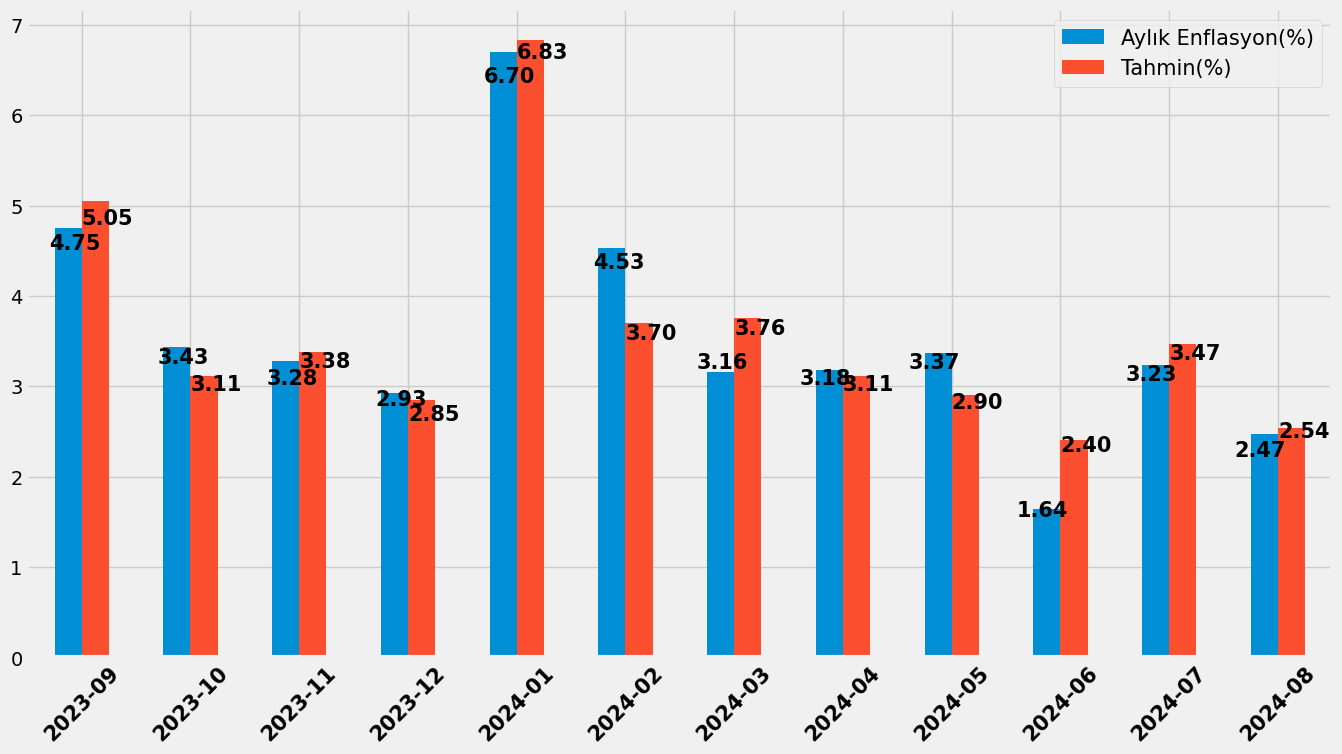

In [141]:
import matplotlib.axes as ax
gecmis=pd.DataFrame({"Aylık Enflasyon(%)":[4.75,3.43,3.28,2.93,6.70,4.53,3.16,3.18,3.37,1.64,3.23,2.47],"Tahmin(%)":[5.05,3.11,3.38,2.85,6.83,3.70,3.76,3.11,2.90,2.40,3.47,2.54]})
gecmis=gecmis.set_index(pd.date_range(start="2023-09-30",periods=12,freq="M"))
gecmis=gecmis.set_index(gecmis.index.strftime("%Y-%m"))
gecmis.plot(kind="bar",figsize=(15,8))
plt.annotate("4.75",xy=(-0.3,gecmis.iloc[0,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("5.05",xy=(0,gecmis.iloc[0,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.43",xy=(0.7,gecmis.iloc[1,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.11",xy=(1,gecmis.iloc[1,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.28",xy=(1.7,gecmis.iloc[2,0]*0.92),fontweight="bold",fontsize=15)
plt.annotate("3.38",xy=(2,gecmis.iloc[2,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("2.93",xy=(2.7,gecmis.iloc[3,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("2.85",xy=(3,gecmis.iloc[3,1]*0.92),fontweight="bold",fontsize=15)
plt.annotate("6.70",xy=(3.7,gecmis.iloc[4,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("6.83",xy=(4,gecmis.iloc[4,1]*0.97),fontweight="bold",fontsize=15)
plt.annotate("4.53",xy=(4.7,gecmis.iloc[5,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.70",xy=(5,gecmis.iloc[5,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.16",xy=(5.65,gecmis.iloc[6,1]*0.85),fontweight="bold",fontsize=15)
plt.annotate("3.76",xy=(6,gecmis.iloc[6,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.18",xy=(6.6,gecmis.iloc[7,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.11",xy=(7,gecmis.iloc[7,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.37",xy=(7.6,gecmis.iloc[8,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("2.90",xy=(8,gecmis.iloc[8,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("1.64",xy=(8.6,gecmis.iloc[9,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("2.40",xy=(9,gecmis.iloc[9,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.23",xy=(9.6,gecmis.iloc[10,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.47",xy=(10,gecmis.iloc[10,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("2.47",xy=(10.6,gecmis.iloc[11,0]*0.90),fontweight="bold",fontsize=15)
plt.annotate("2.54",xy=(11,gecmis.iloc[11,1]*0.96),fontweight="bold",fontsize=15)

plt.legend(fontsize=15)
plt.xticks(rotation=45,fontweight="bold",fontsize=15,color="black")

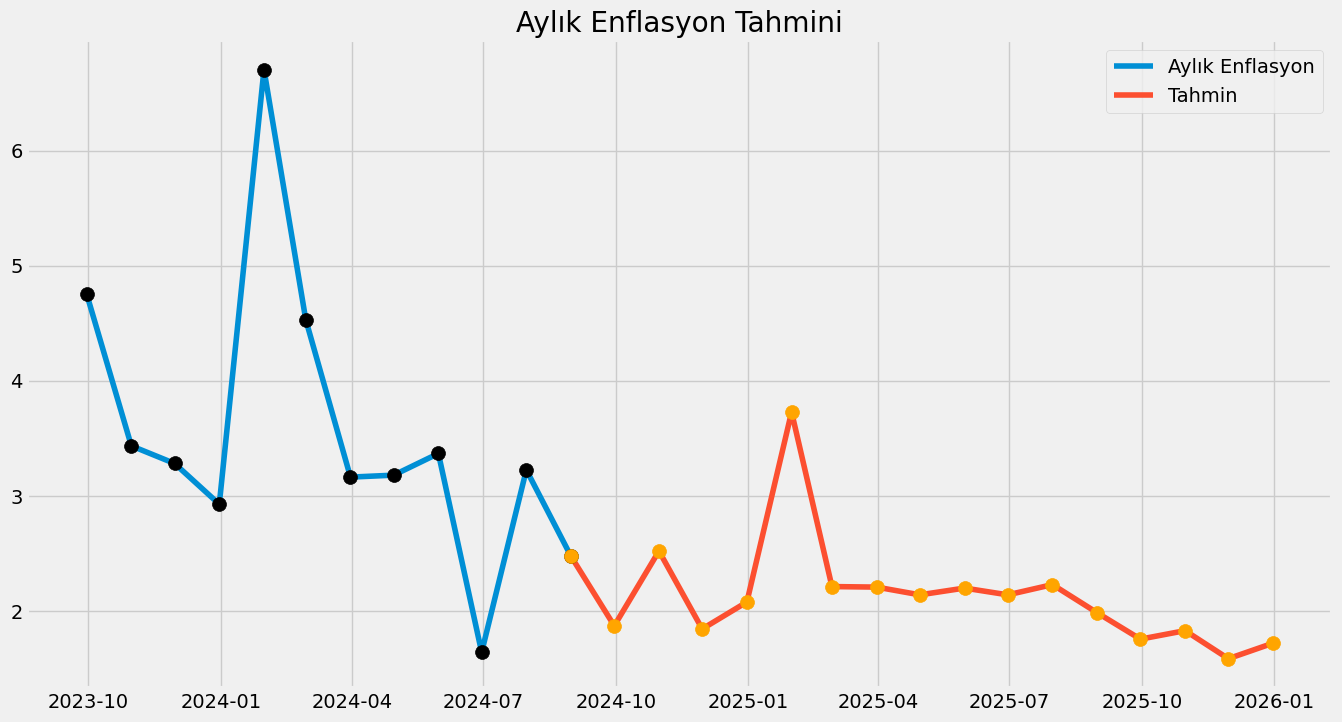

In [142]:
plt.figure(figsize=(15,8))
plt.title("Aylık Enflasyon Tahmini")
plt.plot(aylık.loc["2023-09-30":"2024-08-31"],label="Aylık Enflasyon")
plt.plot(aylık.loc["2024-08-31":"2025-12-31"],label="Tahmin")
plt.scatter(x=aylık.loc["2023-09-30":"2024-08-31"].index,y=aylık.loc["2023-09-30":"2024-08-31"],color="black",s=100,zorder=3)
plt.scatter(x=aylık.loc["2024-08-31":"2025-12-31"].index,y=aylık.loc["2024-08-31":"2025-12-31"],color="orange",s=100,zorder=3)
plt.legend()

findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Fon

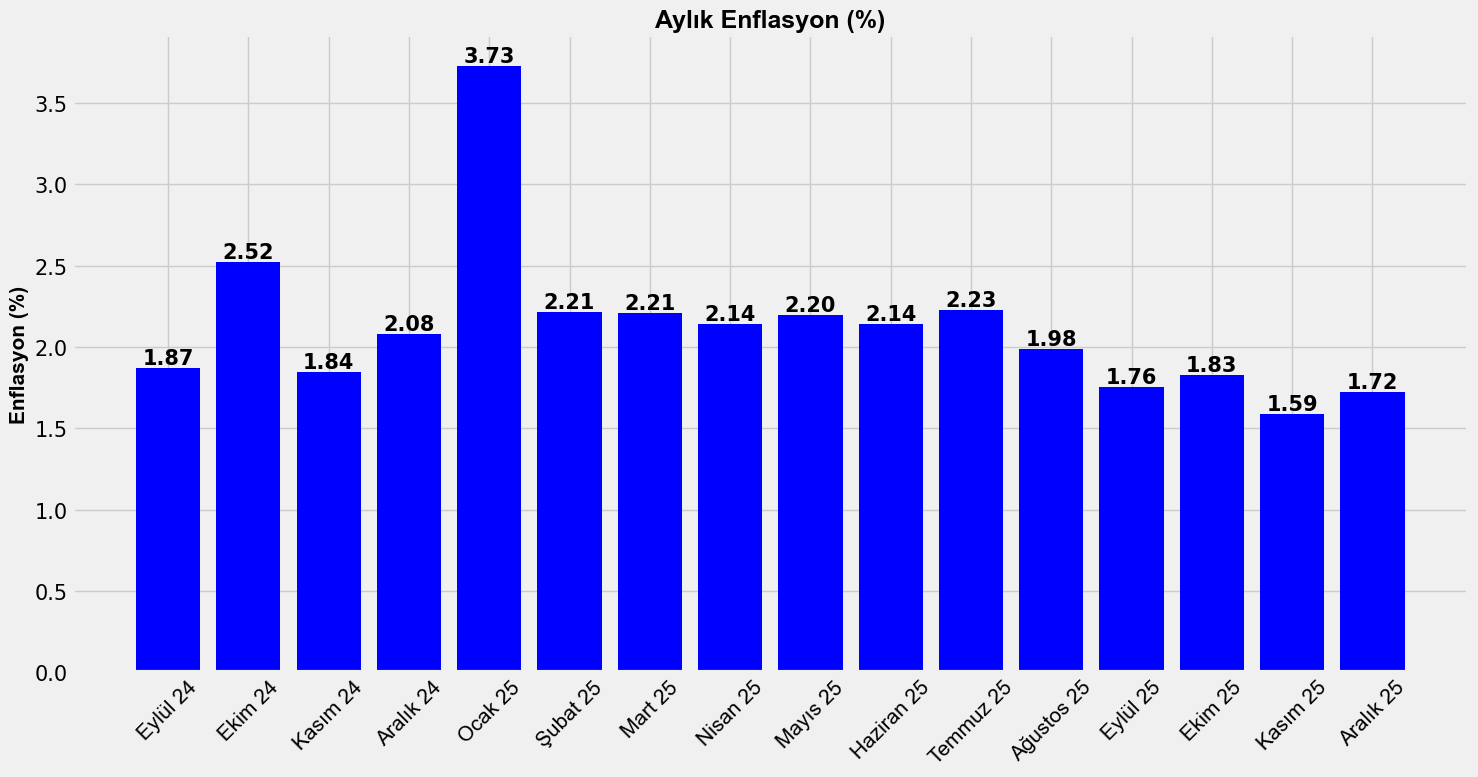

In [143]:

turkish_months = [
    "Eylül 24", "Ekim 24", "Kasım 24", "Aralık 24", "Ocak 25", "Şubat 25",
    "Mart 25", "Nisan 25", "Mayıs 25", "Haziran 25", "Temmuz 25", "Ağustos 25",
    "Eylül 25", "Ekim 25", "Kasım 25", "Aralık 25"
]

# Çubuk grafiği oluşturma
fig, ax = plt.subplots(figsize=(15, 8))
bars = ax.bar(
    turkish_months,
    aylık.loc["2024-09-30":"2025-12-31"],
    color='blue'
)

# Barların üstüne değerleri yazma
for bar, value in zip(bars, aylık.loc["2024-09-30":"2025-12-31"]):
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # X pozisyonu (barın ortası)
        bar.get_height(),  # Y pozisyonu (barın yüksekliği)
        f'{value:.2f}',  # Yazılacak metin (2 ondalık basamak)
        ha='center',  # Metni ortala
        va='bottom',  # Barın üst kısmına yerleştir
        fontsize=15,
        fontweight='bold',
        color='black',
        family="Arial Black"
    )

# X ekseni ayarları
ax.set_xticks(np.arange(len(turkish_months)))
ax.set_xticklabels(turkish_months, rotation=45, fontsize=15, color="black", fontfamily="Arial")

# Y ekseni ayarları
ax.set_ylabel("Enflasyon (%)", fontsize=15, fontweight='bold', color="black", fontfamily="Arial")
ax.tick_params(axis='y', labelsize=15, labelcolor='black')

# Başlık
ax.set_title("Aylık Enflasyon (%)", fontsize=18, fontweight='bold', color="black", fontfamily="Arial")

# Grafik düzenlemesi
plt.tight_layout()
plt.savefig('forecast.png', bbox_inches='tight')
plt.savefig("./monthlyforecasts/" + date.today().strftime("%d-%m-%Y") + '.png', bbox_inches='tight')
plt.show()

findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Font family 'Arial Black' not found.
findfont: Fon

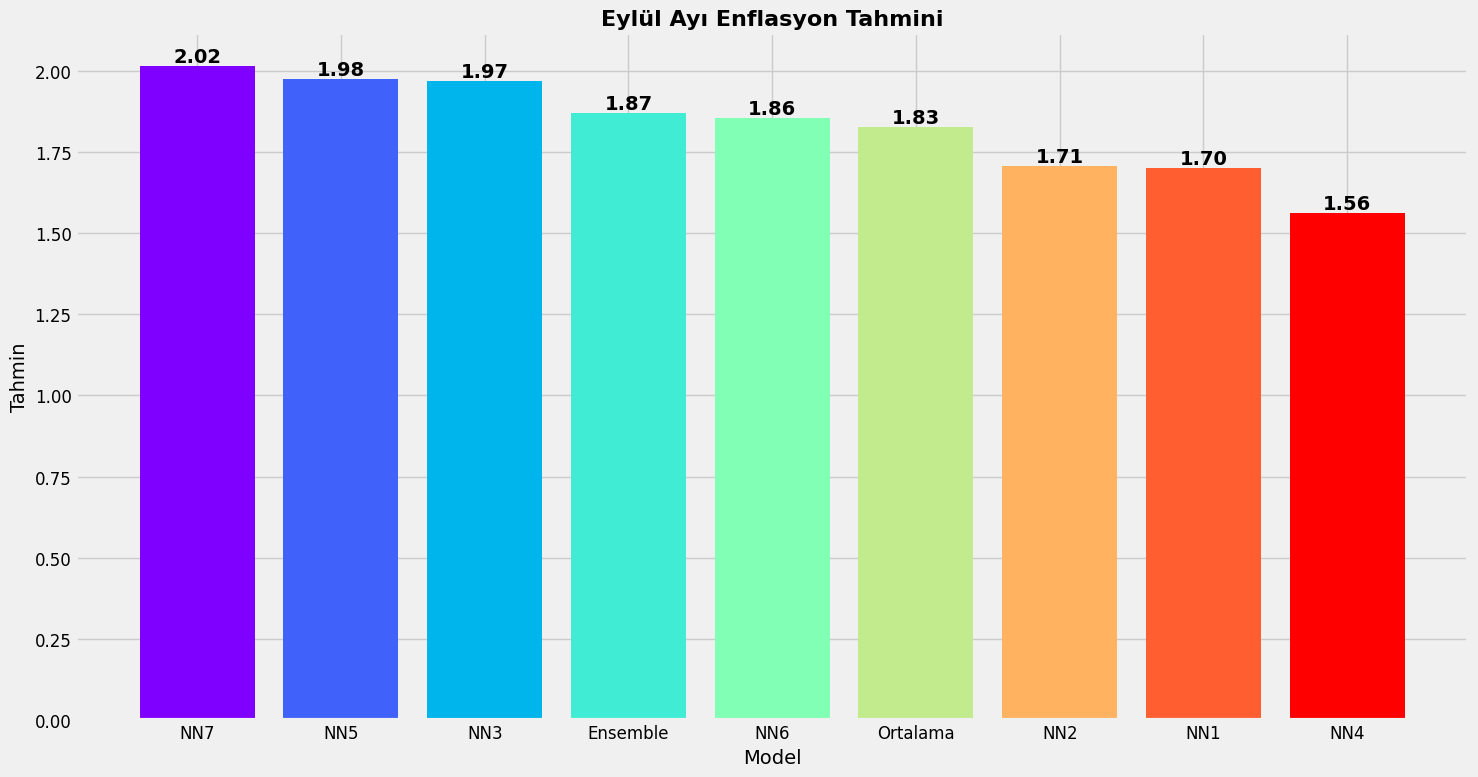

In [144]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.cm as cm
from matplotlib.colors import Normalize

sorted_index = modelaylık.iloc[0, :].sort_values(ascending=False).index
sorted_modelaylık = modelaylık[sorted_index]

# Renk haritasını oluştur (Viridis yerine Rainbow kullanılacak)
colors = cm.rainbow(np.linspace(0, 1, len(sorted_modelaylık.columns)))

# Çubuk grafiği oluşturma
fig, ax = plt.subplots(figsize=(15, 8))

bars = ax.bar(
    sorted_modelaylık.columns,  # X ekseni
    sorted_modelaylık.iloc[0, :].values,  # Y ekseni
    color=colors  # Renk haritası
)

# Çubukların üzerine metin yerleştirme
for bar, value in zip(bars, sorted_modelaylık.iloc[0, :].values):
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # X pozisyonu
        bar.get_height(),  # Y pozisyonu
        f'{value:.2f}',  # Yazılacak metin
        ha='center',  # Ortala
        va='bottom',  # Çubuğun üstüne yerleştir
        fontsize=14,
        color="black",
        fontweight="bold"
    )

# Başlık ve etiketler
ax.set_title("Eylül Ayı Enflasyon Tahmini", fontsize=16, fontweight='bold', fontfamily="Arial Black", color="black")
ax.set_ylabel("Tahmin", fontsize=14, fontfamily="Arial Black", color="black")
ax.set_xlabel("Model", fontsize=14, fontfamily="Arial Black", color="black")

# Eksendeki yazı tiplerini ayarlama
ax.tick_params(axis='x', labelsize=12, colors="black", labelrotation=0)
ax.tick_params(axis='y', labelsize=12, colors="black")

# Grafik düzenlemesi
plt.tight_layout()
plt.savefig("./monthlymodelforecasts/" + date.today().strftime("%d-%m-%Y") + '.png', bbox_inches='tight')


plt.show()

In [145]:
import pandas as pd
from datetime import datetime

# CSV dosyasını oku
csv_file = "C:/Users/Bora/Documents/GitHub/streamlit-inflation/cariay.csv"
df = pd.read_csv(csv_file, index_col=0)

# Bugünün tarihini "dd-mm-yyyy" formatında al
today_date = datetime.today().strftime("%Y-%m-%d")

# Yeni tahmin değeri
new_tahmin = kısatahminler["Ensemble"].iloc[-1]

try:
    df.loc[today_date] = new_tahmin
except:
    pass

# CSV dosyasını güncelle
df.to_csv(csv_file)

print(f"{today_date} tarihli tahmin başarıyla eklendi.")


2024-09-11 tarihli tahmin başarıyla eklendi.


In [146]:
cariay=pd.read_csv("cariay.csv")
cariay=cariay.set_index(pd.to_datetime(cariay["Unnamed: 0"]))
del cariay["Unnamed: 0"]
cariay.index.name=""
cariay

,Tahmin
,
2024-09-04,1.950000
2024-09-05,1.970300
2024-09-06,2.003628
2024-09-09,1.986512


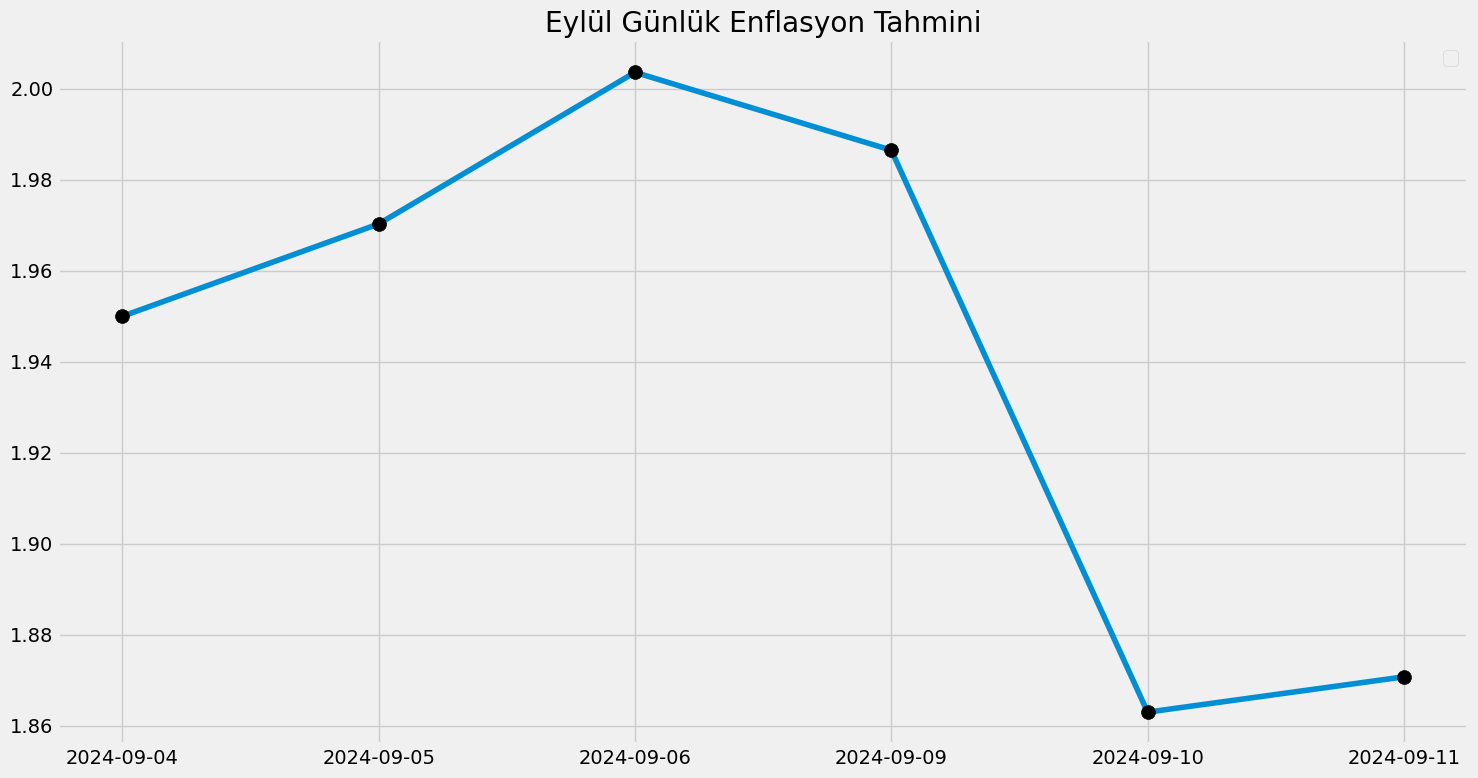

In [147]:
import matplotlib.pyplot as plt
from datetime import date
plt.style.use("fivethirtyeight")
plt.figure(figsize=(15,8))
plt.title("Eylül Günlük Enflasyon Tahmini")
plt.plot(df)
plt.scatter(x=df.index,y=df["Tahmin"],color="black",s=100,zorder=3)
plt.legend()
plt.tight_layout()
plt.savefig("./dailyforecasts/" + date.today().strftime("%d-%m-%Y") + '.png', bbox_inches='tight')